# Exploração de modelos para a previsão de Cancro do Pulmão com base em TAC's



# Introdução e objetivos
O primeiro projecto desta unidade curricular, Laboratórios de IA e CD, consiste em usar imagens como dados de input, mais especificamente de Tomografias Computorizadas (TACs), do tronco humano, de modo a fazer uma classificação quanto à presença ou não de cancro do pulmão no paciente.

O objetivo desta unidade curricular(Lab IA & CD), assim como deste trabalho, é aprofundar os nossos conhecimentos na área da IA e CD, assim como fomentar as nossas capacidades de comunicação, de trabalho em equipa e de desenvolvimento de software.

## Bibliotecas utilizadas

A maioria das bibliotecas utilizadas já são nossas conhecidas de outras UCs, mas decidimos destacar a utilização da biblioteca "radiomics", pois foi a primeira vez que a utilizámos, tendo sido utilizada na obtenção das features através das imagens.


In [24]:
import pylidc as pl
import numpy as np
import matplotlib.pyplot as plt
import pylidc as pl
from pylidc.utils import consensus
import SimpleITK as sitk
import six
from radiomics import featureextractor
import pandas as pd
import statistics

Utilizámos como label as anotações dos radiologistas, por isso, vamos apenas usar as imagens dos pacientes que têm essas anotações. 

O primeiro passo foi extrair as informações das imagens usando a biblioteca radiomics. A cada conjunto de caracteristicas vamos atribuir o id do paciente correspondente e o nódulo em questão, de modo a deixar o paciente certo com o conjunto de caracteristicas e nódulo correspondente. 

In [ ]:
# Configure the PyRadiomics feature extractor
params = {
    'binWidth': 25,  # Adjust parameters as needed
    'resampledPixelSpacing': [1, 1, 1],  # Adjust spacing as needed
    'featureClass': ['firstorder', 'shape', 'glcm', 'glrlm', 'glszm', 'ngtdm', 'gldm','glcmms','gldzm','ngtdmms','glrmms','glszmms']  # Include feature classes
}

extractor = featureextractor.RadiomicsFeatureExtractor(**params)

# Consult all scans with annotations
scans_with_annotations = pl.query(pl.Scan).filter(pl.Scan.annotations.any()).all()

# Lists to store features and patient IDs
features_list = []
patient_ids = []

# Variable to create unique IDs for nodules
nodule_id_counter = 1

# Iterate through all scans with annotations
for scan in scans_with_annotations:
    # Get the ID of the patient
    patient_id = scan.patient_id
    
    # Clusterize the annotations for the scan and retrieve all nodules
    nods = scan.cluster_annotations()
    
    # Iterate through all nodules of the patient
    for anns in nods:
        # Perform consensus clustering with a 50% agreement level
        cmask, cbbox, masks = consensus(anns, clevel=0.5, pad=[(20, 20), (20, 20), (0, 0)])
        
        
        # Convert the pixel array to a SimpleITK image
        image = sitk.GetImageFromArray(cmask.astype(float))
        
        # Extract radiomic features using PyRadiomics
        features = extractor.execute(image, image, label=1)  # Use label 1 for the nodule
        
        # Add the patient ID to the list
        patient_ids.append(patient_id)
        
        # Add a unique ID for the nodule
        features['Nodule_ID'] = f'Nodule_{nodule_id_counter}'
        nodule_id_counter += 1
        
        # Add the features to the list
        features_list.append(features)

# Convert the list of features into a DataFrame
features_df = pd.DataFrame(features_list)

# Add a column "Patient_ID" to the DataFrame
features_df['Patient_ID'] = patient_ids

# Save the selected features to a CSV file
features_df.to_csv('features.csv', index=False)


In [26]:
max=9999999
contador=0
for scan in scans_with_annotations:
    # Get the ID of the patient
    patient_id = scan.patient_id
    
    # Clusterize the annotations for the scan and retrieve all nodules
    nods = scan.cluster_annotations()
    
    # Iterate through all nodules of the patient
    for anns in nods:
        for ann in anns:
            contador+=1
        if contador<max:
            max=contador
        contador=0
print(max)

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
Failed to reduce all groups to <= 4 Annotations.
Some n

O passo seguinte foi a criação de outro df com as anotações para cada par nodulo-paciente.

Para a label (malignancy) usamos uma média pesada, com pesos menores no 1 e maiores no 5 devido ao facto de a mesma indicar precisamente se o nódulo é maligno ou não.

Para os restantes usamos o valor mais comum e quando não existe valor mais comum usamos a média normal. 

In [28]:
# Variable to create unique IDs for nodules
nodule_id_counter = 1
data = []

# Iterate through all scans with annotations
for scan in scans_with_annotations:
    # Get the ID of the patient
    patient_id = scan.patient_id
    
    # Clusterize the annotations for the scan and retrieve all nodules
    nods = scan.cluster_annotations()
    
    # Iterate through all nodules of the patient
    for anns in nods:
        # Calculate the weighted average for "malignancy" with different weights
        malignancy_values = [ann.malignancy for ann in anns]
        weighted_sum = sum(1.25*value if value == 5 else (0.75*value if value == 1 else value) for value in malignancy_values)
        total_weight = sum(1.25 if value == 5 else (0.75 if value == 1 else 1) for value in malignancy_values)
        mean_malignancy = weighted_sum / total_weight if total_weight > 0 else 0

        # Calculate the mode (most common value) for other features
        def calculate_mode(values):
            try:
                return statistics.mode(values)
            except statistics.StatisticsError:
                return np.mean(values)
        
        mode_subtely=calculate_mode([ann.subtlety for ann in anns])
        mode_internalStructure = calculate_mode([ann.internalStructure for ann in anns])
        mode_calcification = calculate_mode([ann.calcification for ann in anns])
        mode_sphericity = calculate_mode([ann.sphericity for ann in anns])
        mode_margin = calculate_mode([ann.margin for ann in anns])
        mode_lobulation = calculate_mode([ann.lobulation for ann in anns])
        mode_spiculation = calculate_mode([ann.spiculation for ann in anns])
        mode_texture = calculate_mode([ann.texture for ann in anns])
        

        # Create a dictionary to store the data
        row = {
            'Patient_ID': patient_id,
            'Nodule_ID': f'Nodule_{nodule_id_counter}',
            'subtlety': mode_subtely,
            'internalStructure': mode_internalStructure,
            'calcification': mode_calcification,
            'sphericity': mode_sphericity,
            'margin': mode_margin,
            'lobulation': mode_lobulation,
            'spiculation': mode_spiculation,
            'texture': mode_texture,
            'malignancy': mean_malignancy
        }
        
        data.append(row)
        nodule_id_counter += 1

# Create a DataFrame from the data
df = pd.DataFrame(data)

# Save the DataFrame to a CSV file
df.to_csv('annotations.csv', index=False)


Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
Failed to reduce all groups to <= 4 Annotations.
Some n

## Tratamento de Dados
#### Bibliotecas utilizadas


In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import RandomizedSearchCV, train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import pandas as pd
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.svm import SVC

Ler as tabelas e criar os valores da label com base na malignancy, isto é, 0 se a malignancy for <= 3, 1 em caso contrário.

Esta label indica se o nódulo do paciente em questão é cancerígeno ou não.

In [30]:
features = pd.read_csv('features.csv')
annot=pd.read_csv('annotations.csv')

In [31]:
values=[]
count1=0
count0=0
for value in annot['malignancy']:
    if value>3:
        values.append(1)
        count1+=1
    else:
        values.append(0)
        count0+=1
y = values  
print(f'Label1: {count1} Label0: {count0}')

Label1: 670 Label0: 1981


É notório o grande desiquilibrio verificado nesta fase entre as classes, o que poderá afetar o modelo. 

Decidimos continuar o trabalho sem efetuar qualquer tipo de alteração nesta questão, apesar de haverem métodos possiveis para o fazer, como Data Augmentation/Reduction e de acreditarmos que se o fizéssemos teríamos melhores resultados.

Aqui podemos visualizar todas as colunas.

In [32]:
for column in features.columns:
    print(column)

diagnostics_Versions_PyRadiomics
diagnostics_Versions_Numpy
diagnostics_Versions_SimpleITK
diagnostics_Versions_PyWavelet
diagnostics_Versions_Python
diagnostics_Configuration_Settings
diagnostics_Configuration_EnabledImageTypes
diagnostics_Image-original_Hash
diagnostics_Image-original_Dimensionality
diagnostics_Image-original_Spacing
diagnostics_Image-original_Size
diagnostics_Image-original_Mean
diagnostics_Image-original_Minimum
diagnostics_Image-original_Maximum
diagnostics_Mask-original_Hash
diagnostics_Mask-original_Spacing
diagnostics_Mask-original_Size
diagnostics_Mask-original_BoundingBox
diagnostics_Mask-original_VoxelNum
diagnostics_Mask-original_VolumeNum
diagnostics_Mask-original_CenterOfMassIndex
diagnostics_Mask-original_CenterOfMass
diagnostics_Image-interpolated_Spacing
diagnostics_Image-interpolated_Size
diagnostics_Image-interpolated_Mean
diagnostics_Image-interpolated_Minimum
diagnostics_Image-interpolated_Maximum
diagnostics_Mask-interpolated_Spacing
diagnostics_M

Todas as colunas que mencionam "diagnostics" são referentes a variáveis de versões e de caracteristicas que são irrelevantes para o modelo, logo podemos eliminar.

Isto deve-se ao facto de as features que decidimos manter estarem nomeadas com "orginal_ngtdm_(nome da feature)". 

In [33]:
feat = features.iloc[:,37:-2] 
for column in feat.columns:
    print(column)

original_shape_Elongation
original_shape_Flatness
original_shape_LeastAxisLength
original_shape_MajorAxisLength
original_shape_Maximum2DDiameterColumn
original_shape_Maximum2DDiameterRow
original_shape_Maximum2DDiameterSlice
original_shape_Maximum3DDiameter
original_shape_MeshVolume
original_shape_MinorAxisLength
original_shape_Sphericity
original_shape_SurfaceArea
original_shape_SurfaceVolumeRatio
original_shape_VoxelVolume
original_firstorder_10Percentile
original_firstorder_90Percentile
original_firstorder_Energy
original_firstorder_Entropy
original_firstorder_InterquartileRange
original_firstorder_Kurtosis
original_firstorder_Maximum
original_firstorder_MeanAbsoluteDeviation
original_firstorder_Mean
original_firstorder_Median
original_firstorder_Minimum
original_firstorder_Range
original_firstorder_RobustMeanAbsoluteDeviation
original_firstorder_RootMeanSquared
original_firstorder_Skewness
original_firstorder_TotalEnergy
original_firstorder_Uniformity
original_firstorder_Variance
o

In [34]:

InputData=pd.concat([annot,feat],axis=1)
InputData.to_csv('complete_data.csv',index=False)
index=InputData.iloc[:,0:2]
X = InputData.drop(InputData.columns[[0,1]],axis=1)
X.drop(['malignancy'],axis=1,inplace=True)

Decidimos fazer um StandardScaler de modo a por todas as varíaveis na mesma escala, e efetuamos a divisão do dataset em 70% training set e 30% test set.

In [35]:
scaler = StandardScaler()

X_continuous = scaler.fit_transform(X)

scaled = pd.DataFrame(X_continuous, columns=X.columns)

In [36]:
X_train, X_test, y_train, y_test = train_test_split(scaled, y, test_size=0.3)

# Criação dos modelos e resultados iniciais
## Implementação do primeiro modelo - Random Forest

O primeiro modelo que decidimos criar foi um Random Forest. 

Tomamos esta decisão pois sabemos que o mesmo é capaz de lidar com a grande dimensionalidade dos dados e iterar nos parametros para obter um possível melhor resultado nestas condições.

Optamos também por utilizar uma função GridSearchCV, que efetua cross-validation, o que permite treinar o modelo com conjuntos de treino diferentes.

Fitting 5 folds for each of 108 candidates, totalling 540 fits


/home/guilherme/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
180 fits failed out of a total of 540.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
180 fits failed with the following error:
Traceback (most recent call last):
  File "/home/guilherme/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/guilherme/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 340, in fit
    self._validate_params()
  File "/home/guilherme/.local/lib/python3.8/site-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/home/

RandomForestClassifier(min_samples_leaf=2, n_estimators=200)
              precision    recall  f1-score   support

           0       0.90      0.95      0.92       602
           1       0.80      0.67      0.73       194

    accuracy                           0.88       796
   macro avg       0.85      0.81      0.83       796
weighted avg       0.88      0.88      0.88       796

Accuracy: 0.8793969849246231
Precision: 0.8024691358024691
Recall: 0.6701030927835051


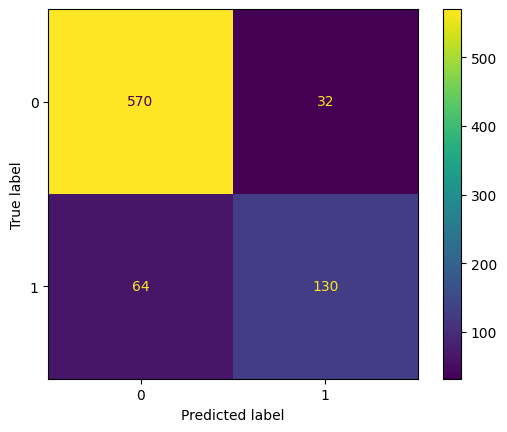

In [37]:
param_grid={'max_depth':[3,5,10,None],
              'n_estimators':[10,100,200],
              'min_samples_leaf':[1,2,3],
              'min_samples_split':[1,2,3]
           }


grid = GridSearchCV(RandomForestClassifier(),param_grid,refit=True,verbose=1);
grid.fit(X_train, y_train)
print(grid.best_estimator_)

grid_predictions = grid.predict(X_test)
print(classification_report(y_test,grid_predictions))


cm = confusion_matrix(y_test, grid_predictions)
ConfusionMatrixDisplay(confusion_matrix=cm).plot();

accuracy = accuracy_score(y_test, grid_predictions)
precision = precision_score(y_test, grid_predictions)
recall = recall_score(y_test, grid_predictions)

best_rf_nda=grid

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)



In [38]:
print(grid.best_params_)

{'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}


Fazendo uma análise preliminar dos resultados, podemos verificar que a accuracy está intermédia, assim como o recall.

Acreditamos que equilibrar as classes pode ser uma possível solução para obter uma melhor accuracy, algo que será abordado mais à frente no trabalho.

## Implementação do segundo modelo - SVM

Optámos por implementar uma SVM (support vector machine), devido à sua particular eficiência em problemas de classificação como o do trabalho proposto.

Fitting 5 folds for each of 64 candidates, totalling 320 fits
SVC(C=0.1, gamma=1, kernel='linear')
              precision    recall  f1-score   support

           0       0.91      0.95      0.93       602
           1       0.83      0.71      0.76       194

    accuracy                           0.89       796
   macro avg       0.87      0.83      0.85       796
weighted avg       0.89      0.89      0.89       796



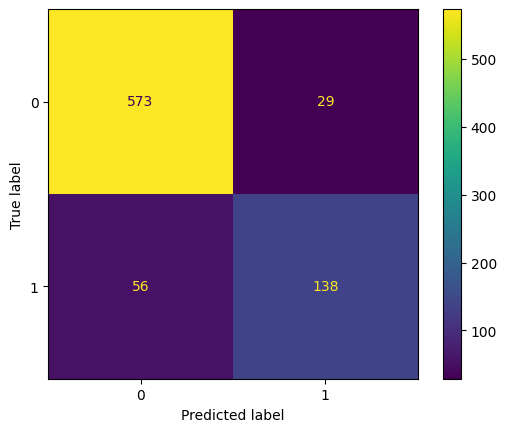

In [39]:
melhor=0

param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid','linear']}
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=1);
grid.fit(X_train, y_train)
print(grid.best_estimator_)

grid_predictions = grid.predict(X_test)
print(classification_report(y_test,grid_predictions))

best_svm_nda=grid

cm = confusion_matrix(y_test, grid_predictions)
ConfusionMatrixDisplay(confusion_matrix=cm).plot();

O modelo SVM apresenta uma ligeira melhoria em termos de accuracy quando comparado ao random forrest implementado anteriormente. Isto deve-se ao facto de apresentar menos falsos positivos.

# Implementação do terceiro modelo - KNN

Decidimos implementar o KNN pois é para nós um modelo já muito conhecido e de fácil implementação, por isso também a titulo de curiosidade decidimos comparar o seu desempenho com os restantes modelos implementados.

Acurácia: 0.8944723618090452
Precision: 0.8353658536585366
Recall: 0.7061855670103093
35


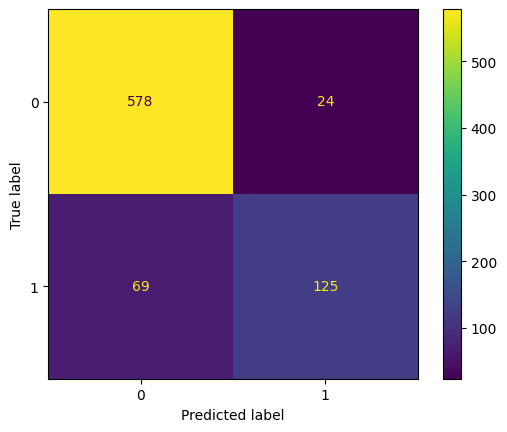

In [40]:
from sklearn.neighbors import KNeighborsClassifier

melhor=0

for k in range(1,100):
    # Você pode ajustar esse valor
    knn_classifier = KNeighborsClassifier(n_neighbors=k)

    # Treine o classificador com os dados de treinamento
    knn_classifier.fit(X_train, y_train)

    # Faça previsões no conjunto de teste
    y_pred = knn_classifier.predict(X_test)

    # Calcule a precisão das previsões
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    if accuracy>melhor:
        melhork=k
        melhor=accuracy
        melhorp=precision
        melhorr=recall
        best_knn_nda=knn_classifier
print(f"Acurácia: {melhor}")
print("Precision:", melhorp)
print("Recall:", melhorr)
print(melhork)
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot();

O resultado obtido não foi surpreendente, sendo muito parecido com o do random forest.

Ainda assim, optámos por implementar um último modelo para ver se haveria alguma mudança na previsão.  

# Implementação do quarto modelo - Rede neuronal

Por ultimo criamos uma NN a iterar em vários parametros e a devolver o melhor modelo possivel.

Decidimos usar uma NN porque achamos que os dados são bastante complexos e se torna bastante dificil para um dos outros algoritmos detetar esses padrões.

In [42]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

In [43]:



X_NN = X_train.values.tolist()
y_NN = y_train



hidden_layer_sizes = [64, 128, 256]
epochs_list = [50, 100]
learnRate = [0.01,0.1,0.5]

best_accuracy = 0
best_model = None
best_loss = None

accuracies = []
losses = []


for hidden_layers in hidden_layer_sizes:
    for epochs in epochs_list:
        for learningRate in learnRate:

            model = Sequential()
            for i in range(2):
                model.add(Dense(hidden_layers, activation='relu', input_shape=(X_train.shape[1],)))
                
            model.add(Dense(1, activation='softmax'))  # Camada de output


            model.compile(loss='binary_crossentropy', optimizer=Adam(learningRate), metrics=['accuracy'])


            history = model.fit(X_NN, y_NN, epochs=epochs, verbose=0)  # verbose=0 para evitar logs 


            loss, accuracy = model.evaluate(X_test.values.tolist(), y_test, verbose=0)

            
            accuracies.append(accuracy)
            losses.append(loss)
        
            
            if accuracy > best_accuracy:
                best_hidden_layer_sizes =hidden_layers
                best_epochs_list = epochs
                best_accuracy = accuracy
                best_model = model
                best_loss = loss


print(f"Melhor Acurácia encontrada: {best_accuracy:.2f}")
print(f"Loss do Melhor Modelo: {best_loss:.2f}")
print(f"melhor numero de camadas ocultas: {best_hidden_layer_sizes}")
print(f"Melhor numero de epochs: {best_epochs_list}")
best_NN_nda=best_model

Melhor Acurácia encontrada: 0.24
Loss do Melhor Modelo: 0.71
melhor numero de camadas ocultas: 64
Melhor numero de epochs: 50


In [44]:
loss, accuracy = best_model.evaluate(X_test.values.tolist(), y_test, verbose=0)      
print(loss)
print(accuracy)
print(best_model.summary())

0.7050725221633911
0.24371859431266785
Model: "sequential_326"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_978 (Dense)           (None, 64)                7424      
                                                                 
 dense_979 (Dense)           (None, 64)                4160      
                                                                 
 dense_980 (Dense)           (None, 1)                 65        
                                                                 
Total params: 11,649
Trainable params: 11,649
Non-trainable params: 0
_________________________________________________________________
None


In [45]:
predictions = (model.predict(X_test.values.tolist()) > 0.5).astype(int)
from sklearn.metrics import classification_report
y_pred_bool = np.argmax(predictions, axis=1)

print(classification_report(y_test, y_pred_bool))

25/25 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.76      1.00      0.86       602
           1       0.00      0.00      0.00       194

    accuracy                           0.76       796
   macro avg       0.38      0.50      0.43       796
weighted avg       0.57      0.76      0.65       796



/home/guilherme/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guilherme/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guilherme/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


A accuracy verificada na NN foi bastante inferior à dos outros modelos, algo que na nossa visão se deve dever ao facto de as classes nâo estarem equilibradas.

# Alteração nos dados - Data augmentation e eliminação de outliers

Para melhorar os resultados obtidos anteriormente, decidimos fazer um equilibrio das classes utilizando data augmentation e eliminação de outliers que são classificados como 0 (sem cancro).

Tomámos esta decisão pois a eliminação de outliers é uma boa maneira de equilibrar os dados mas os outliers classificados como 1 (com cancro) serão de interesse para o nosso modelo. Assim, eliminámos as linhas classificadas como outliers em pelo menos 21 caracteríscas.

Para o fazer, utilizamos a biblioteca "imblearn".

In [47]:
from imblearn.over_sampling import SMOTE
from collections import Counter

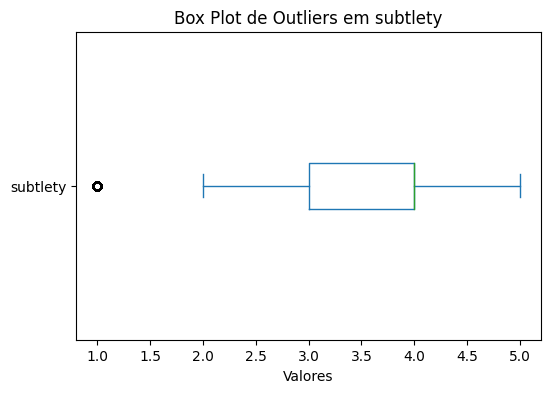

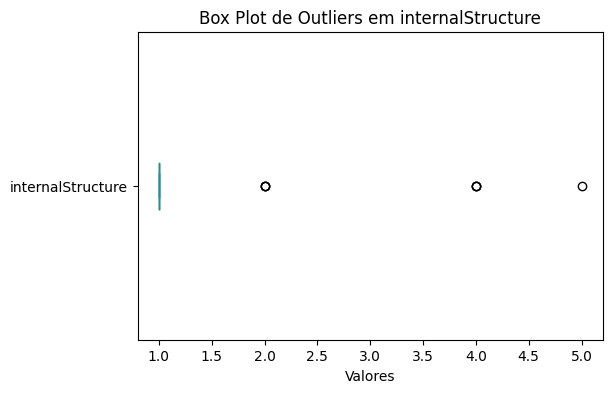

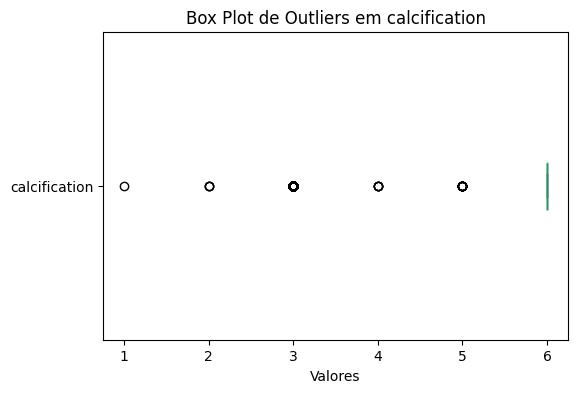

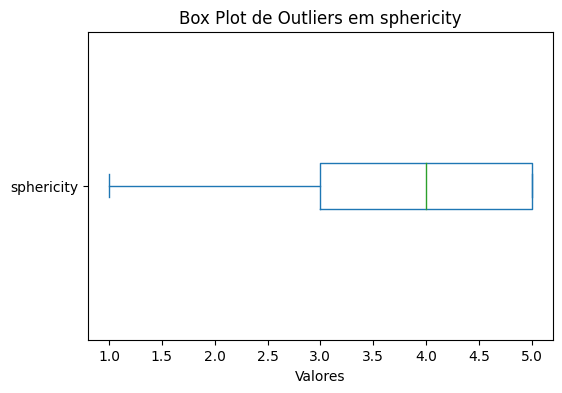

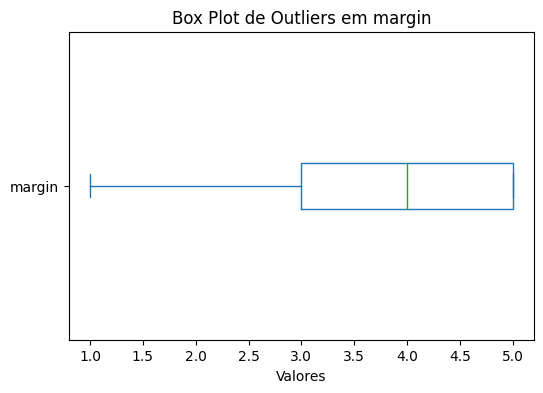

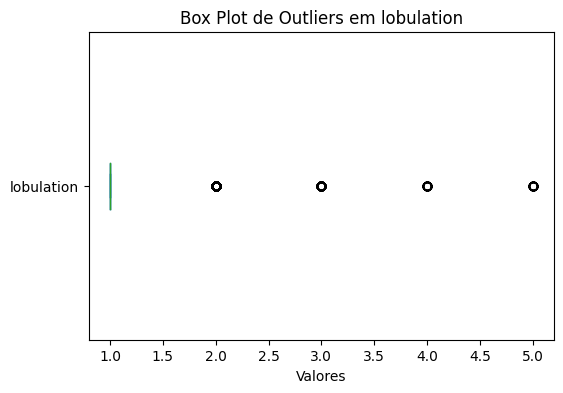

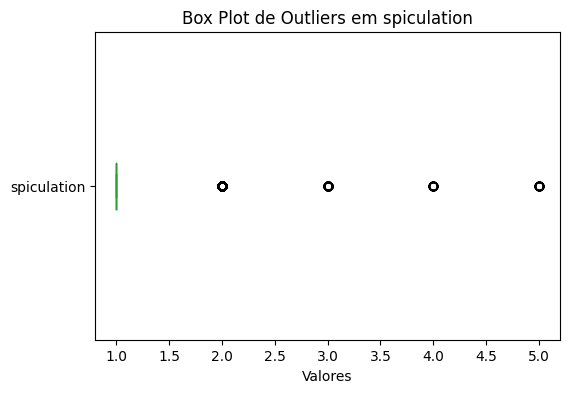

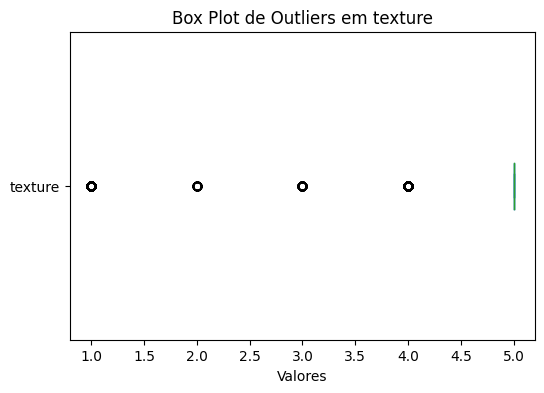

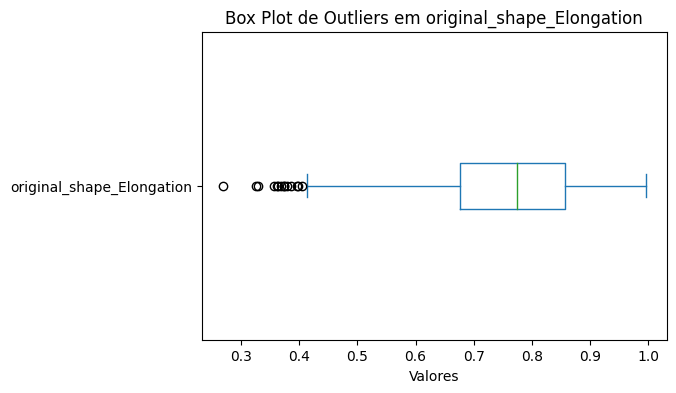

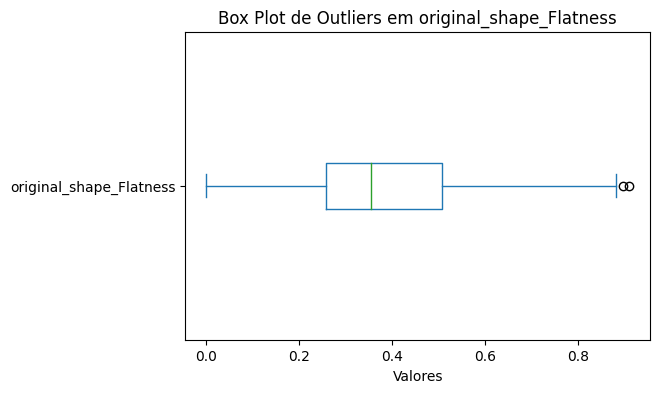

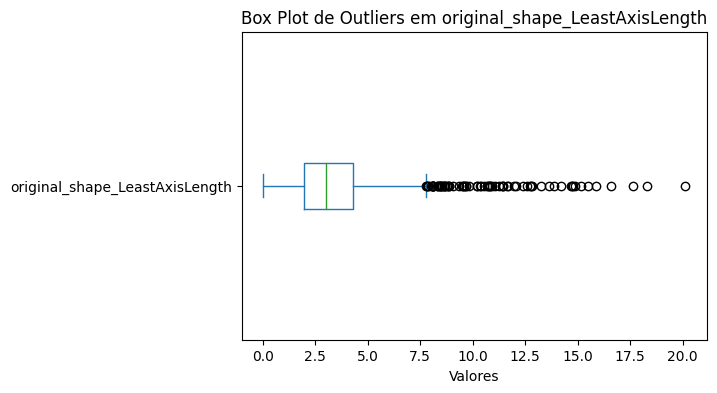

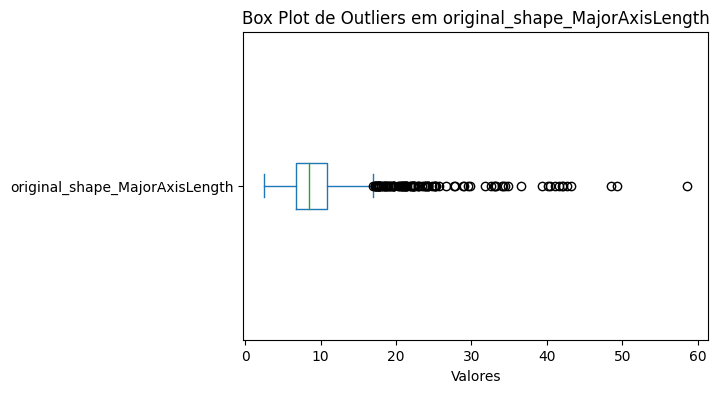

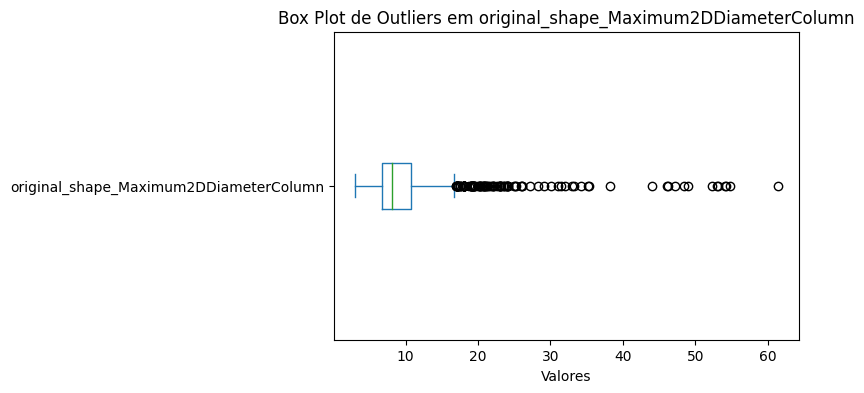

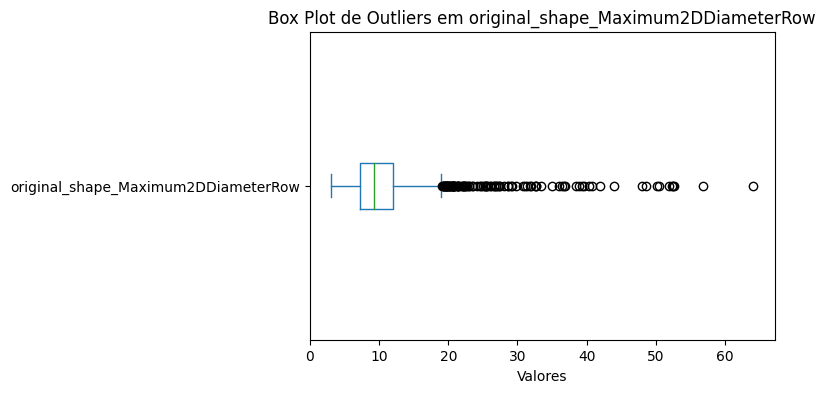

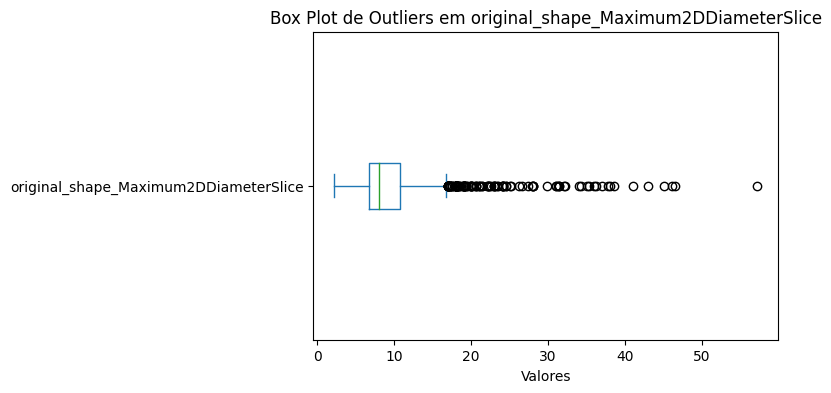

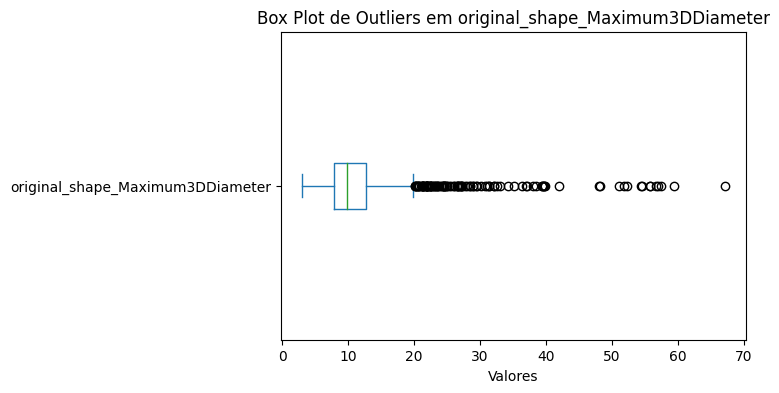

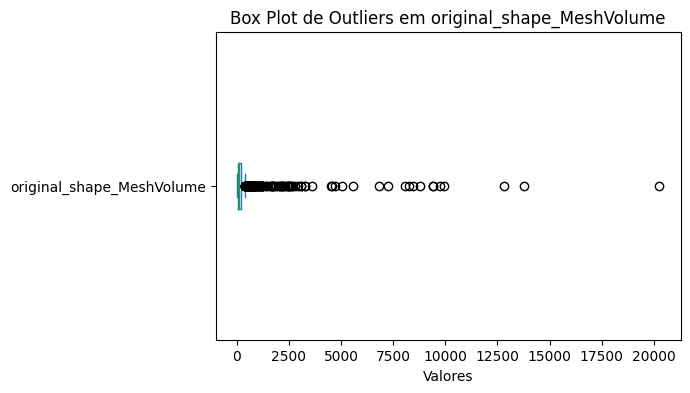

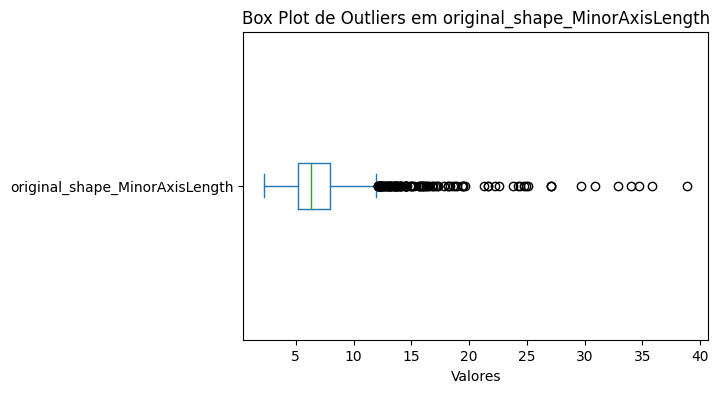

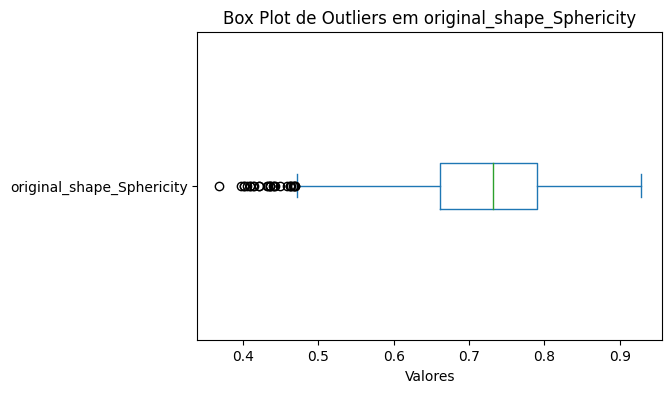

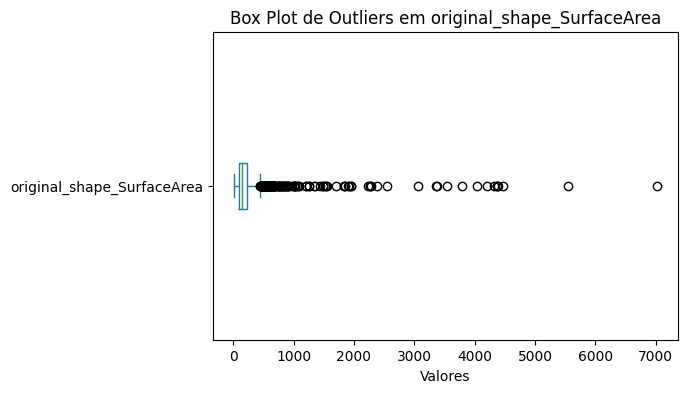

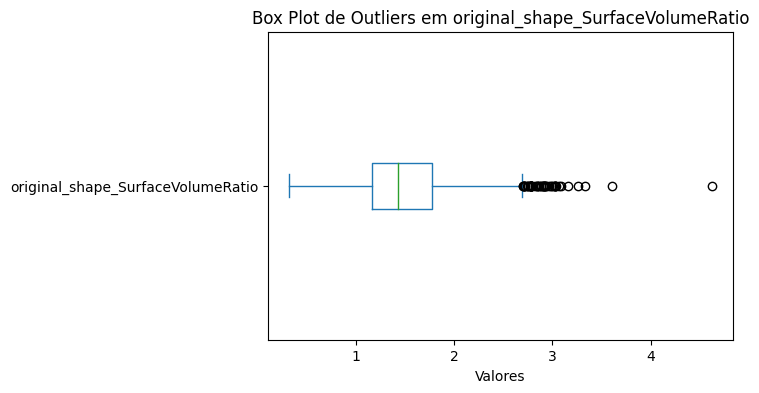

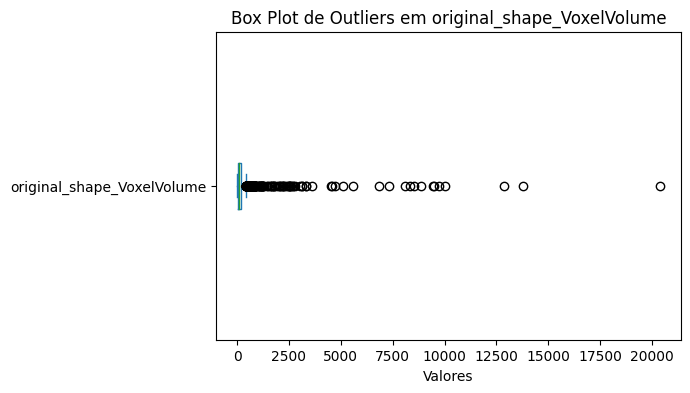

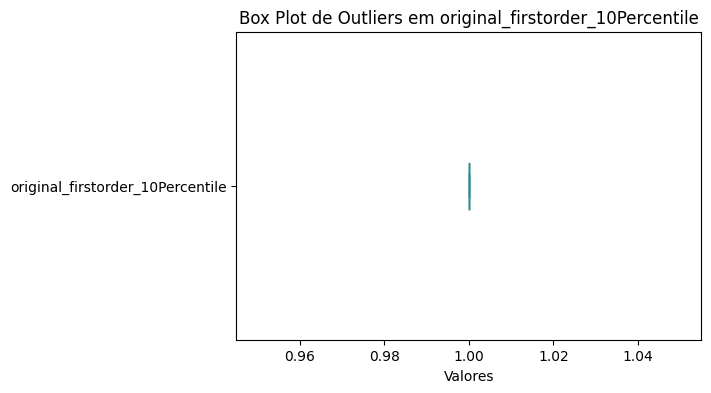

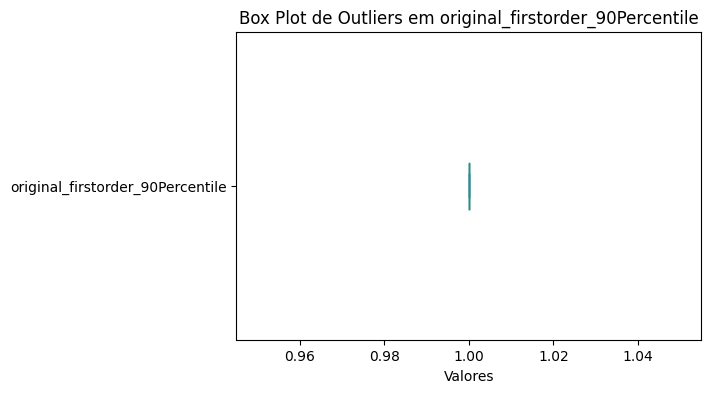

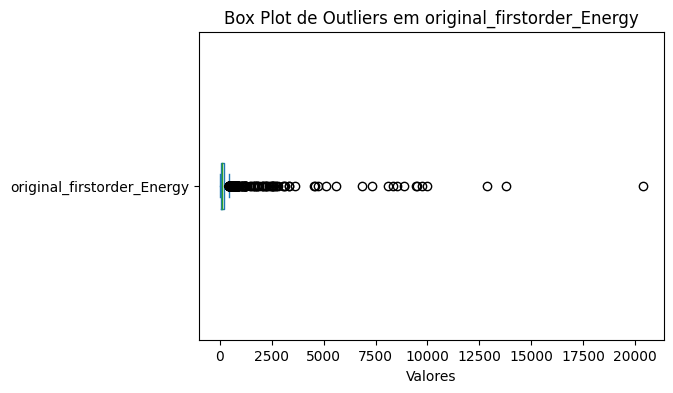

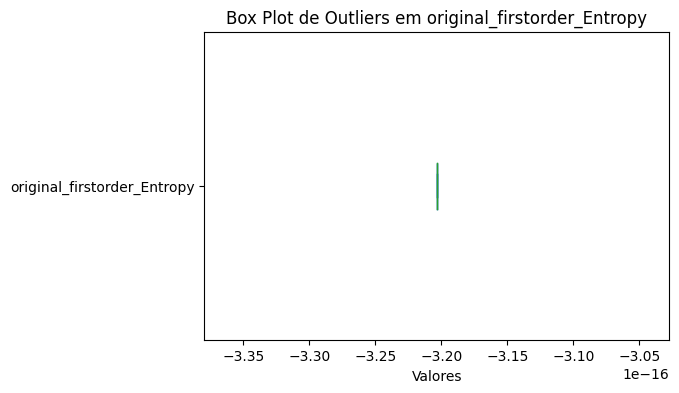

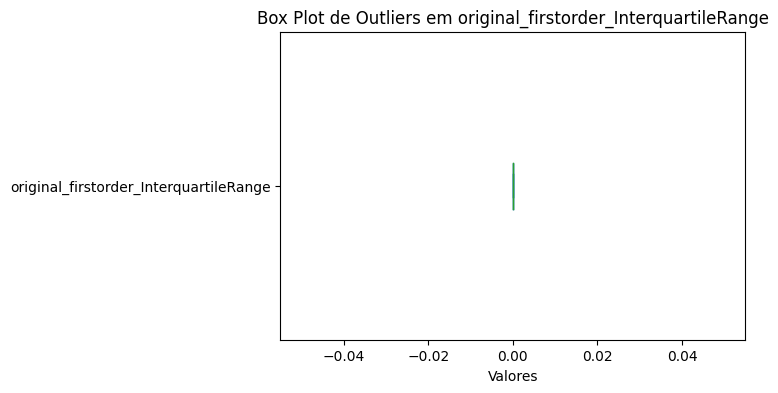

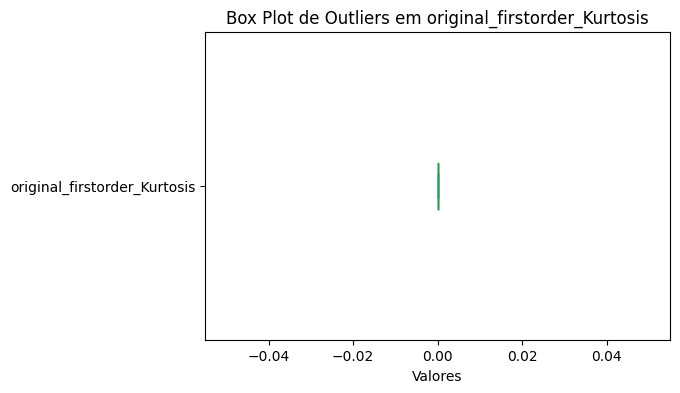

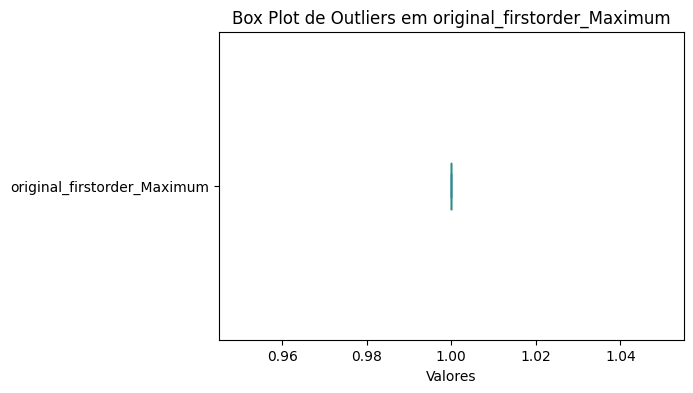

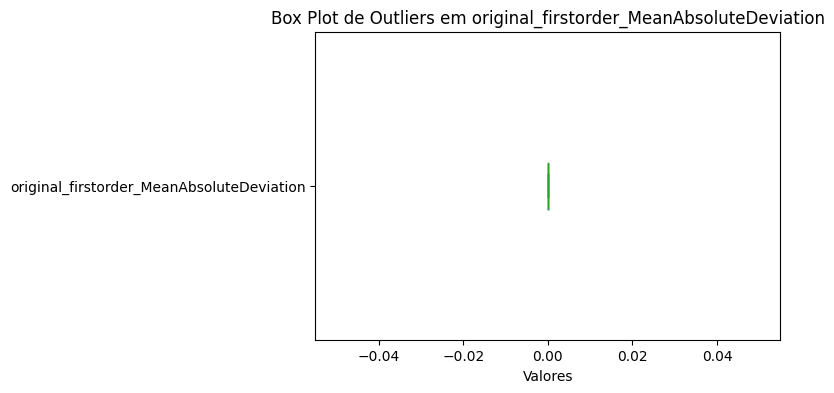

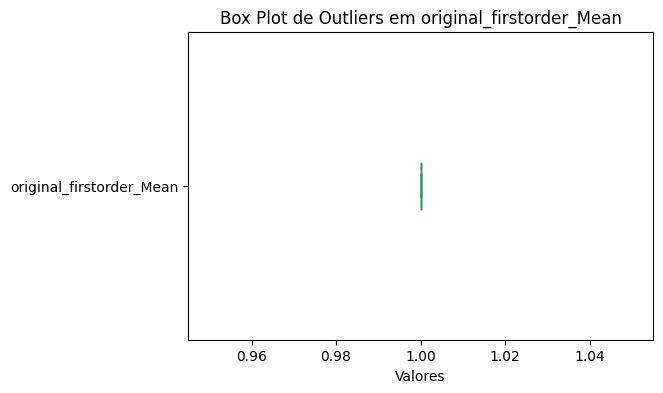

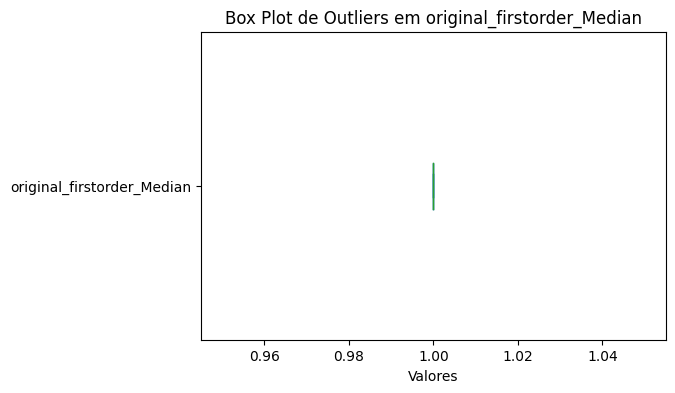

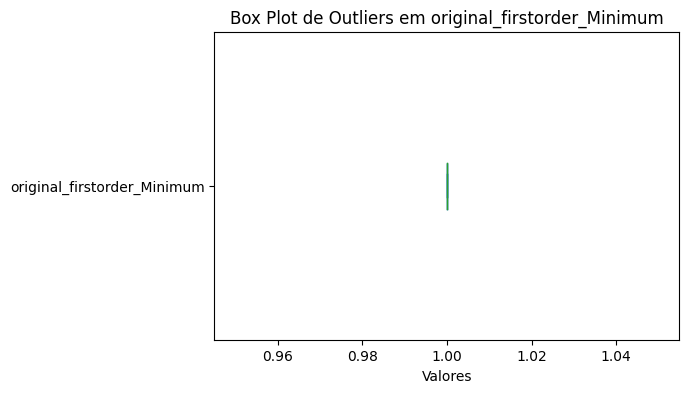

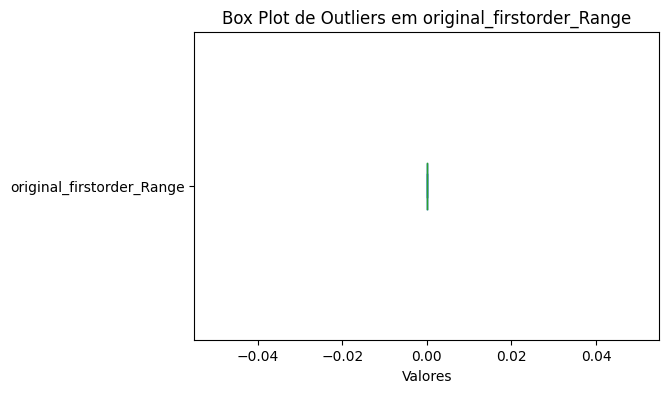

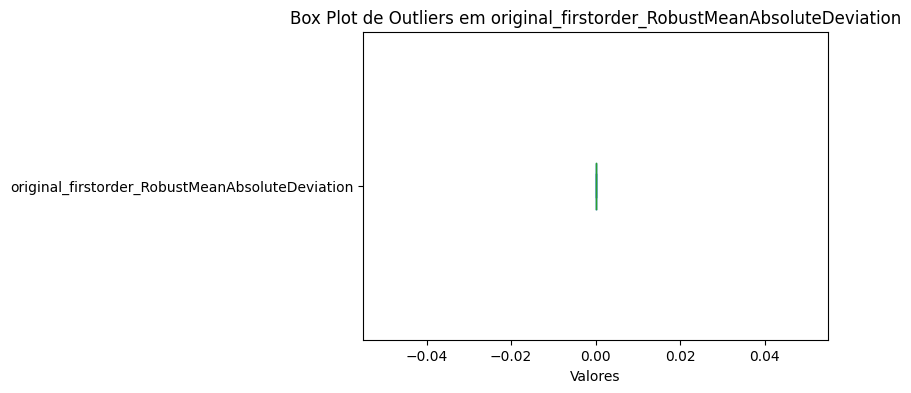

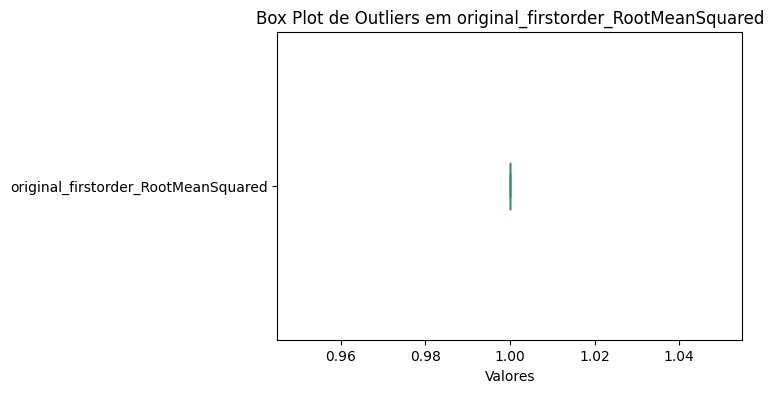

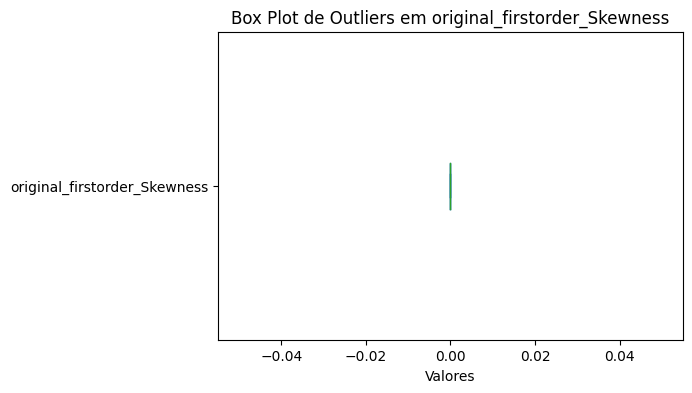

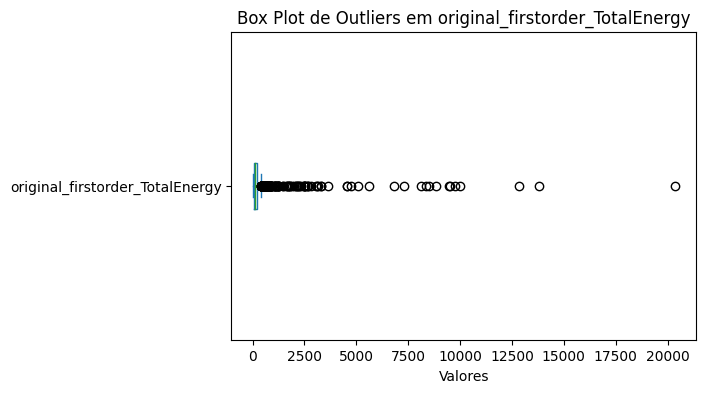

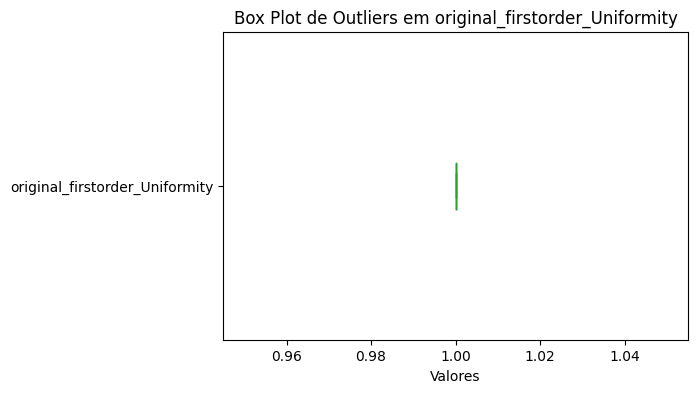

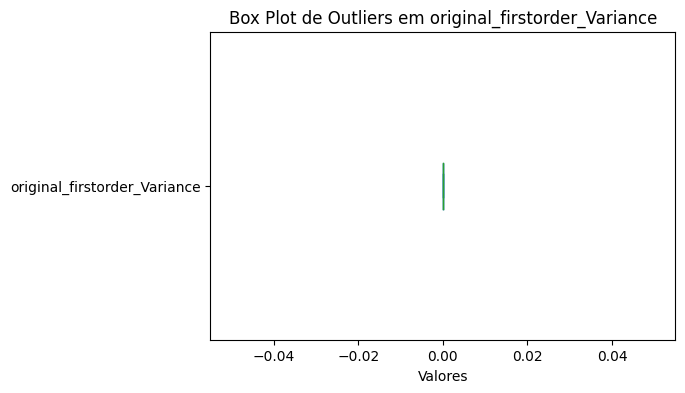

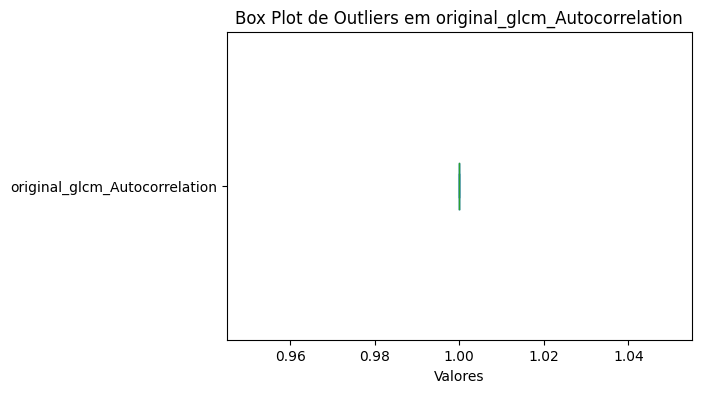

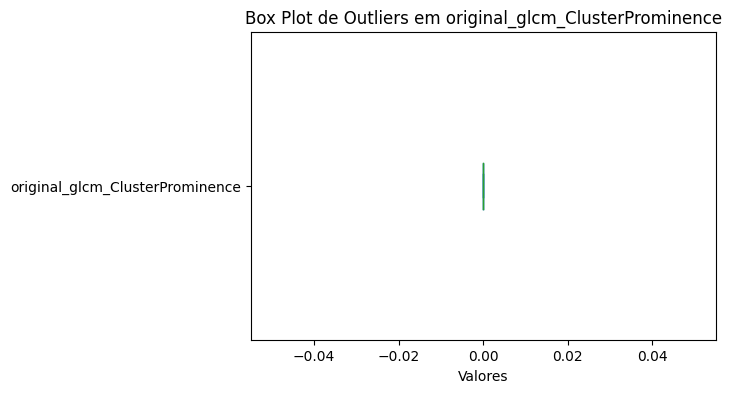

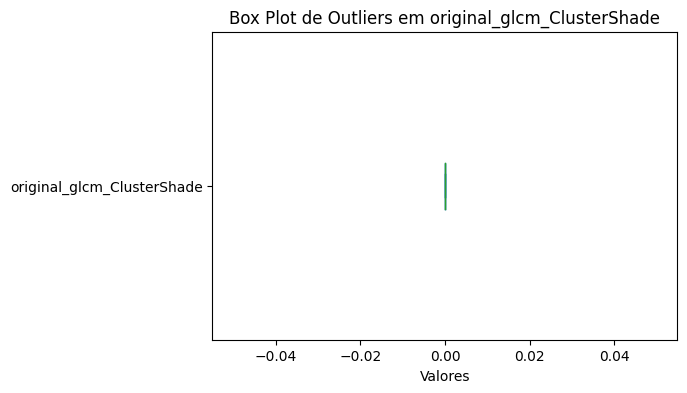

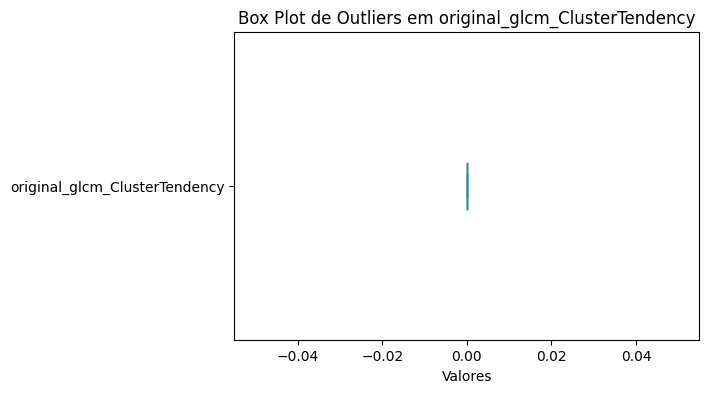

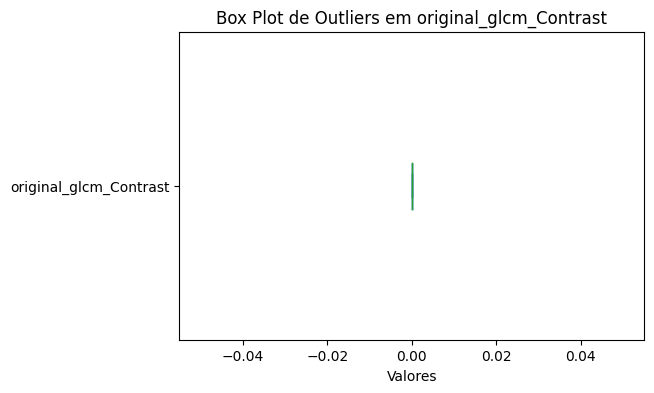

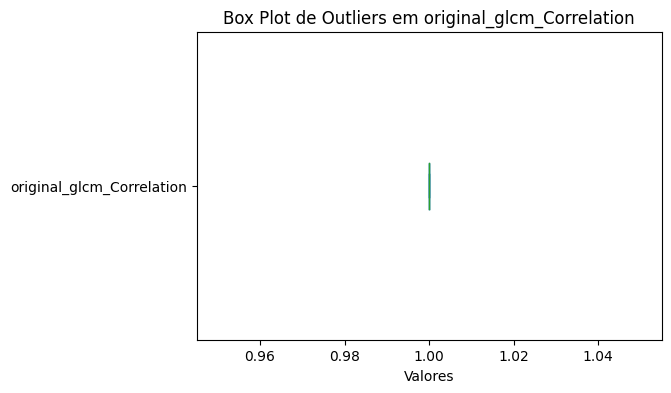

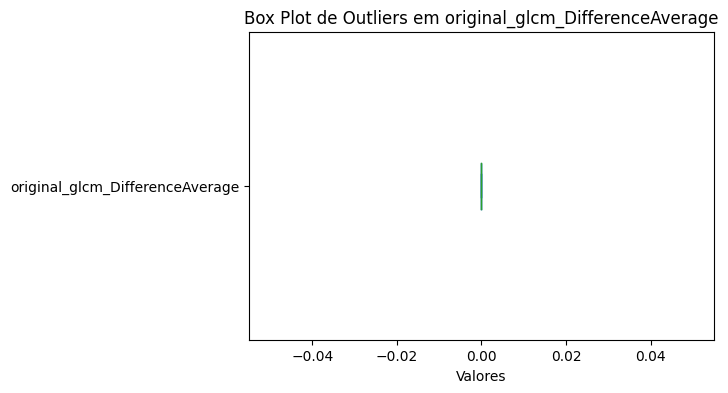

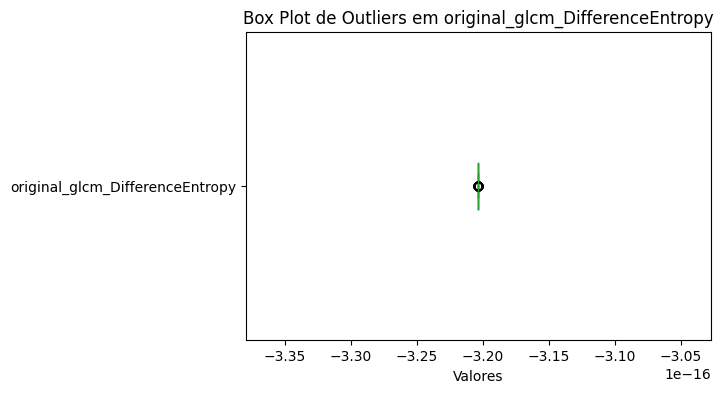

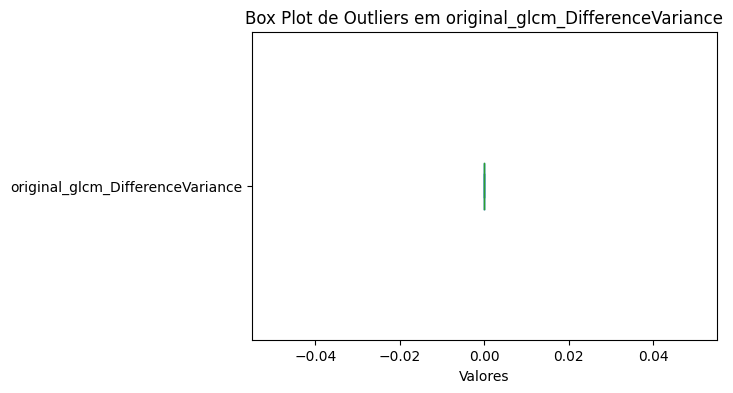

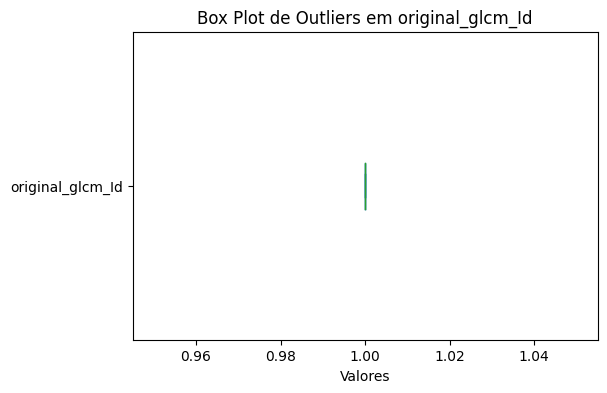

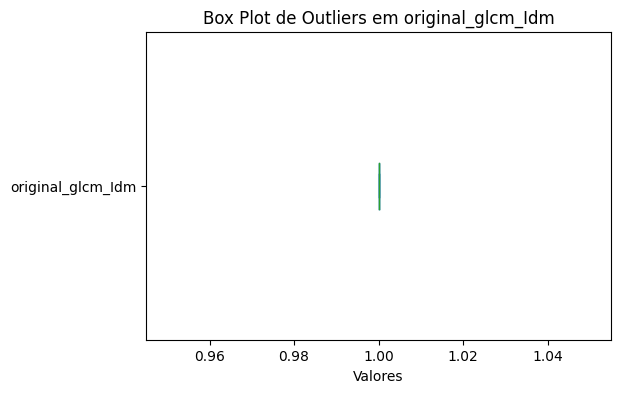

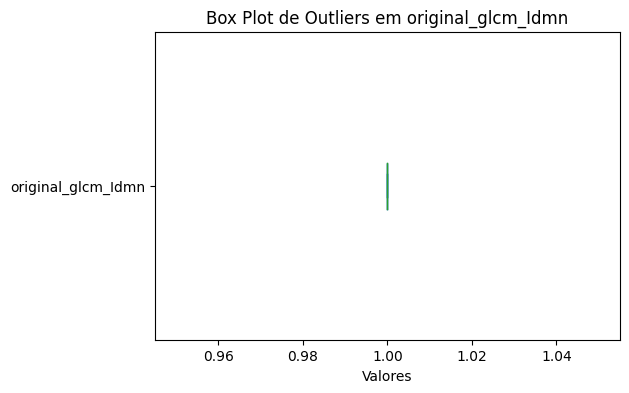

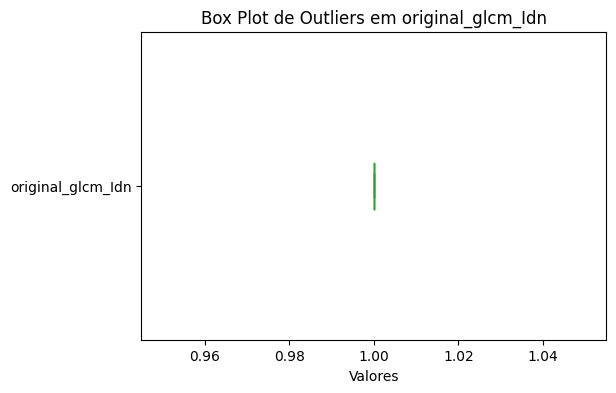

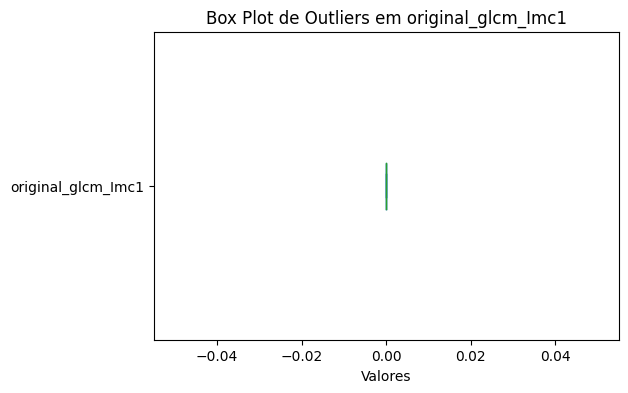

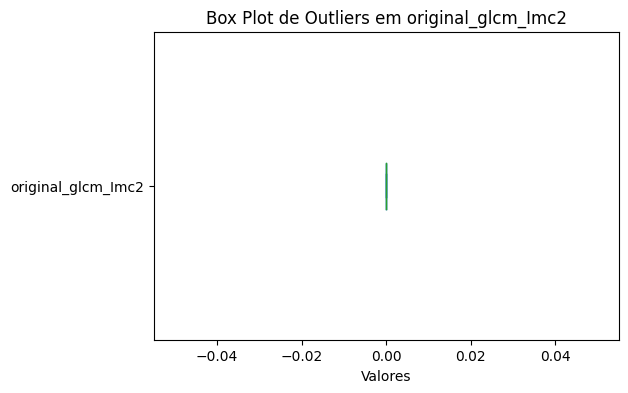

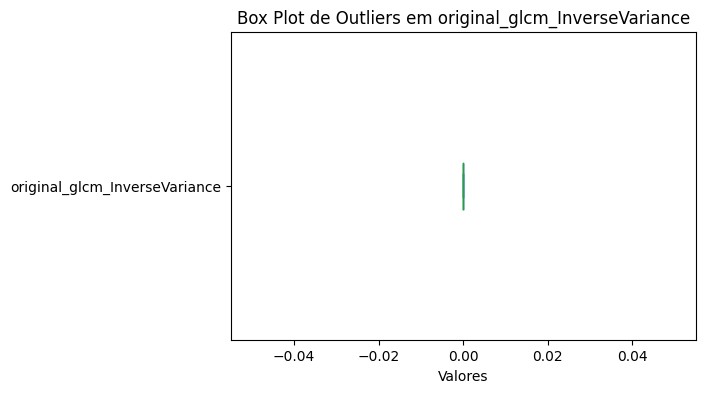

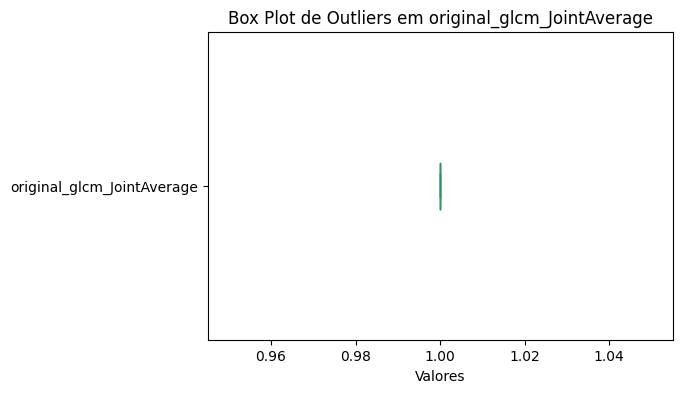

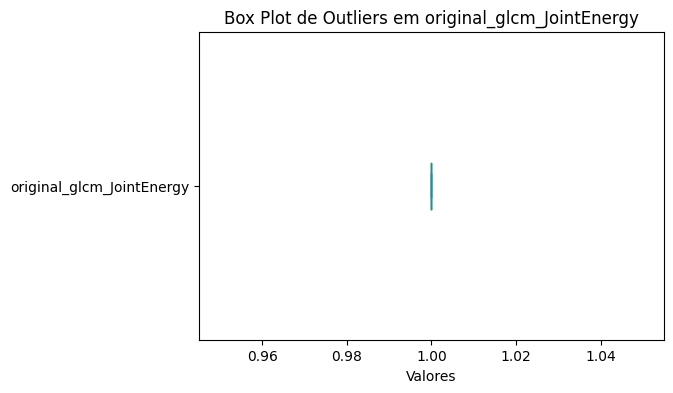

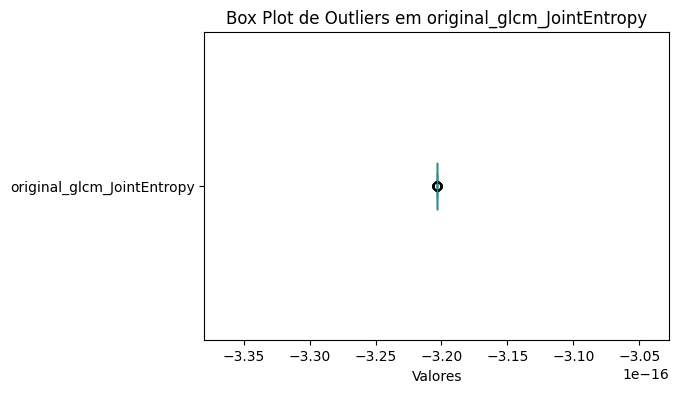

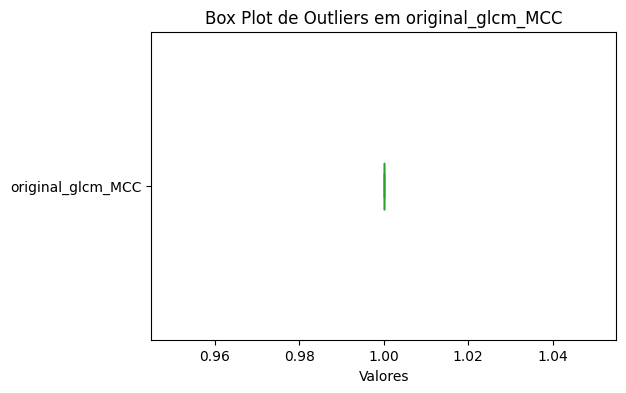

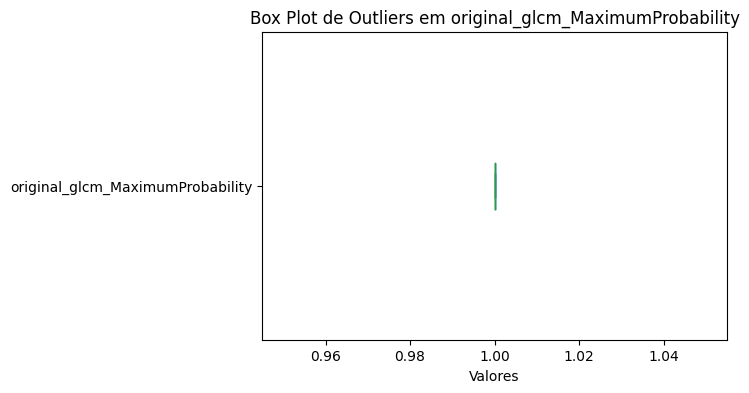

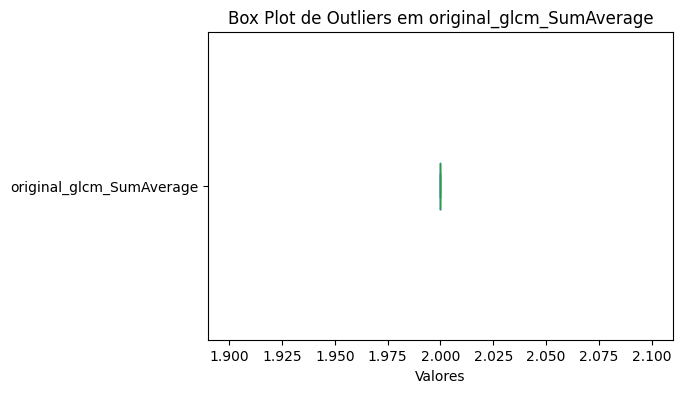

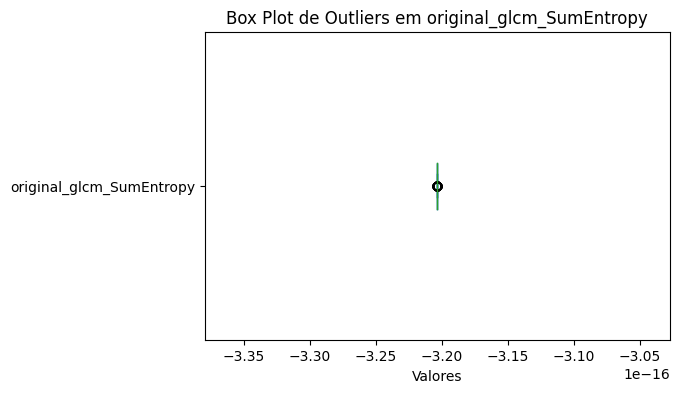

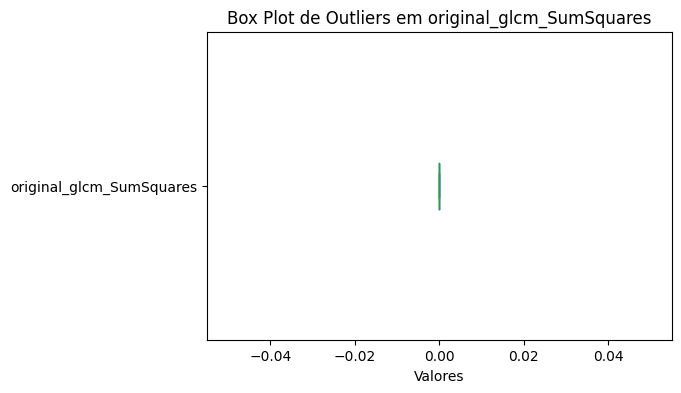

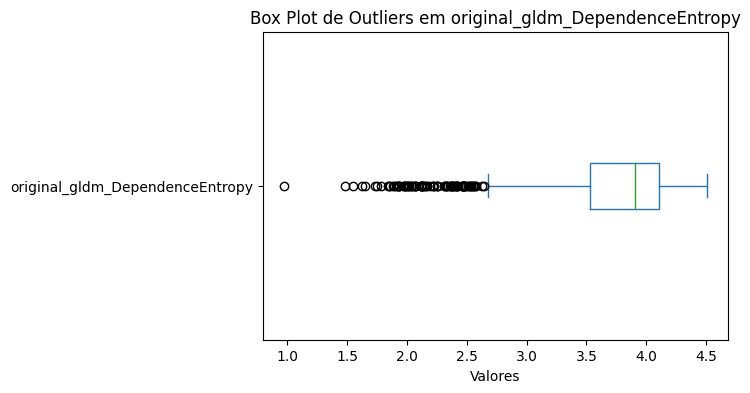

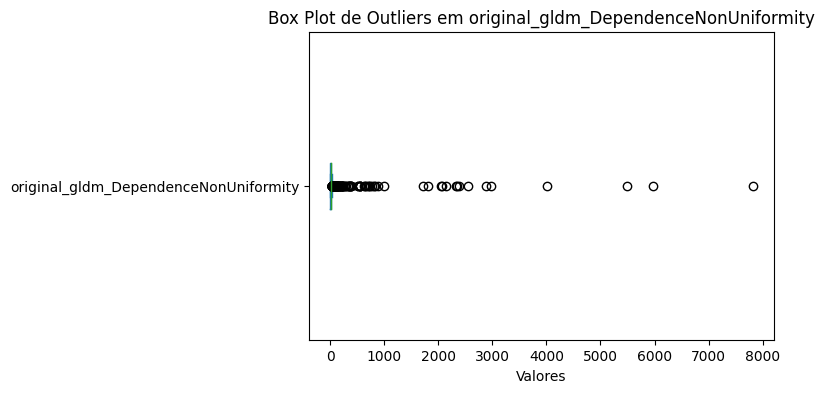

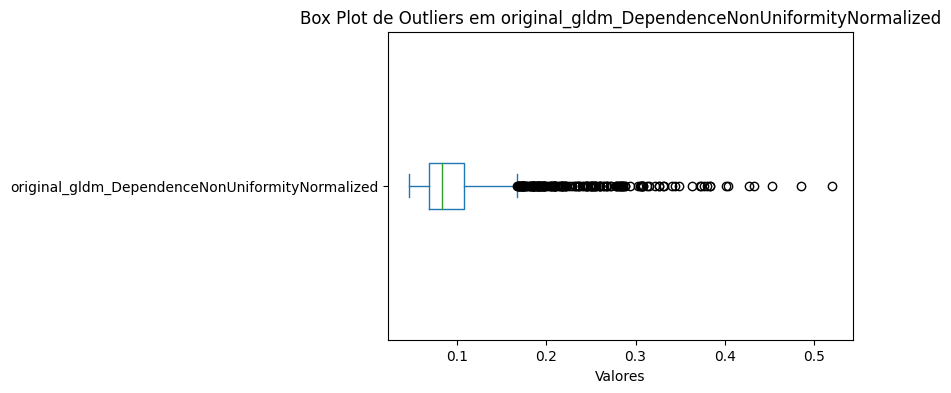

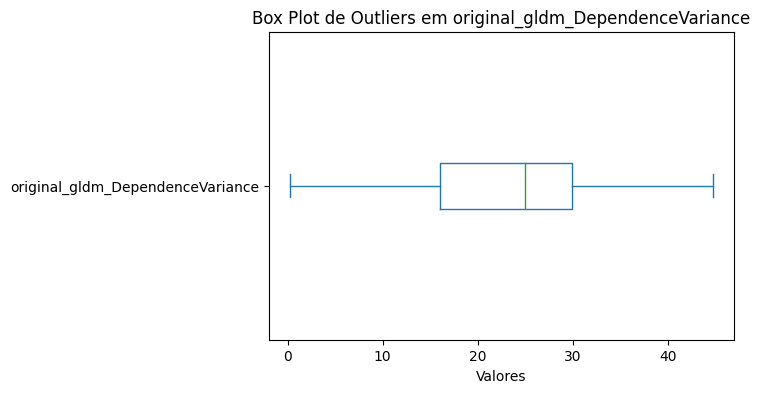

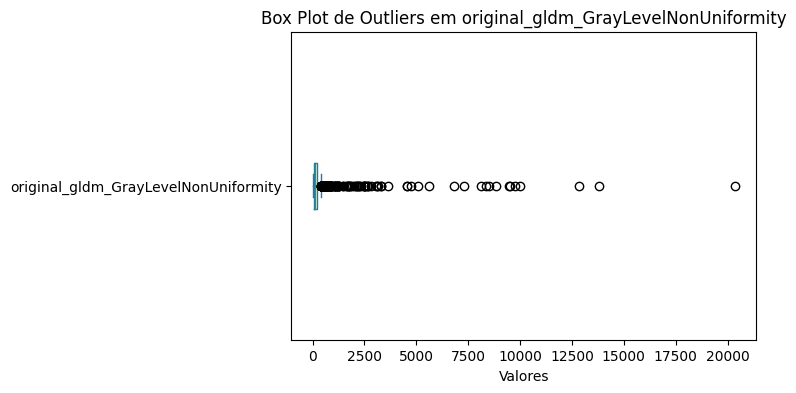

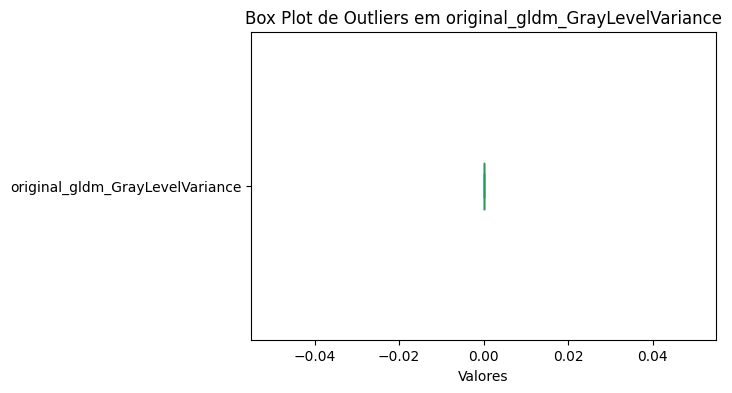

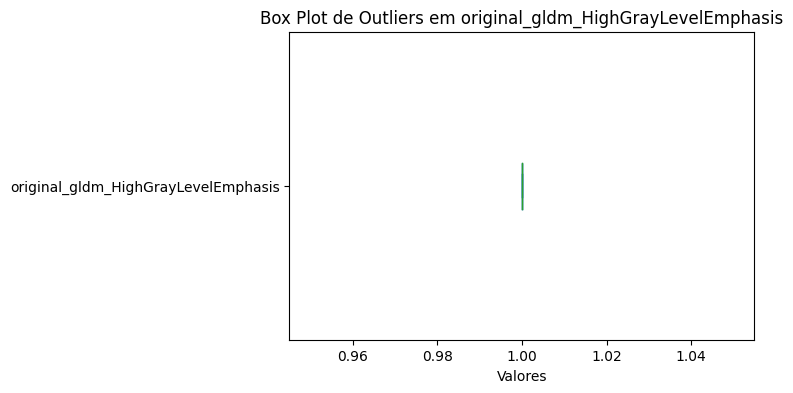

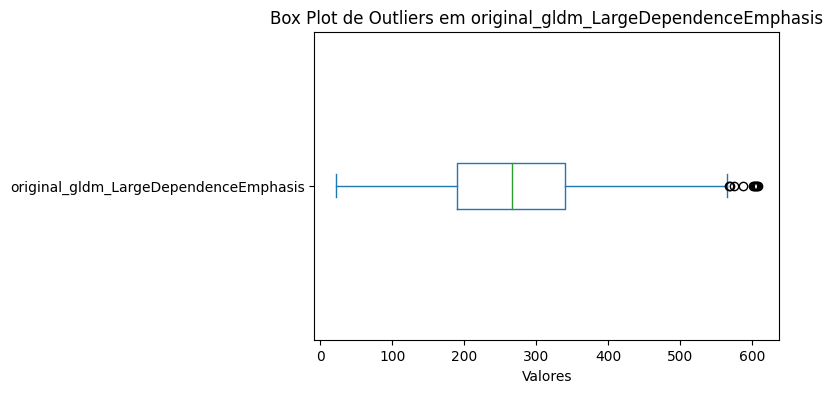

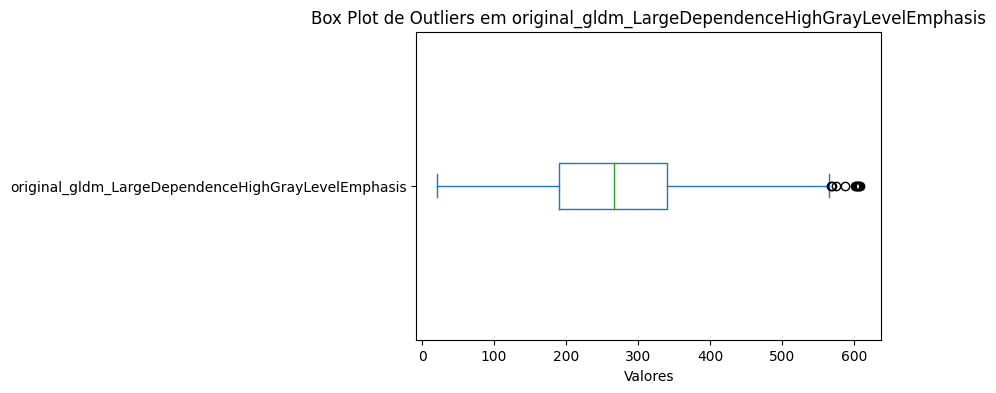

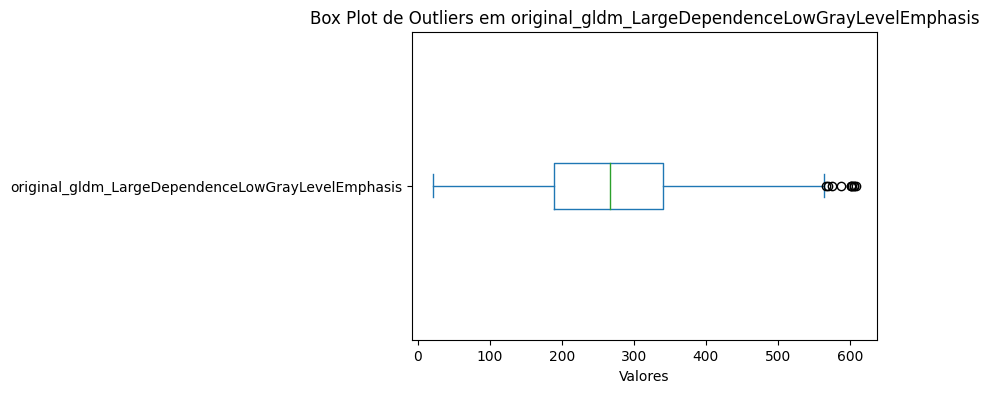

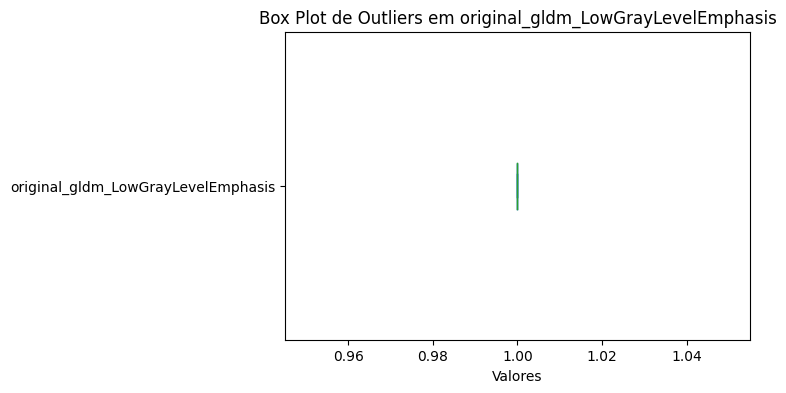

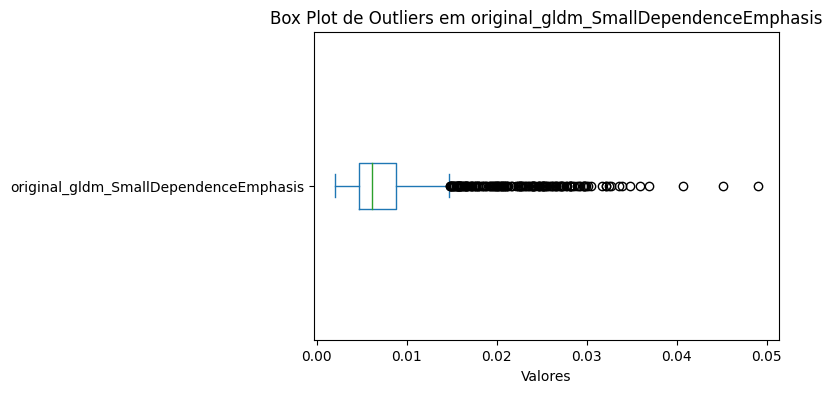

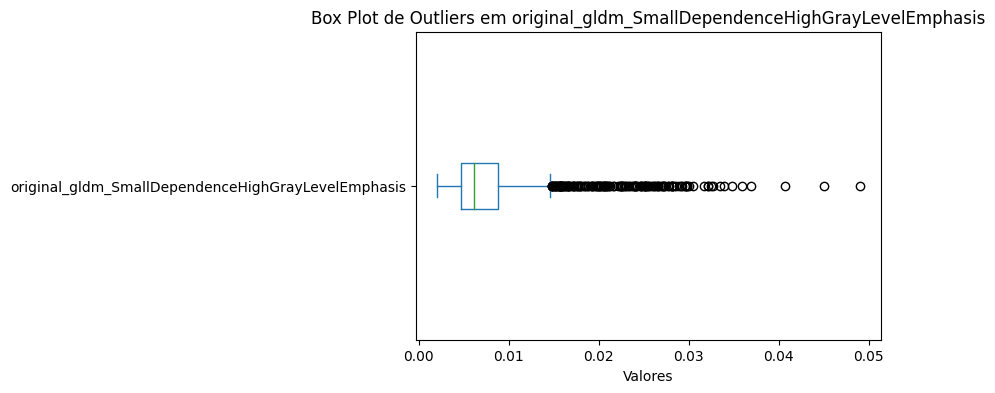

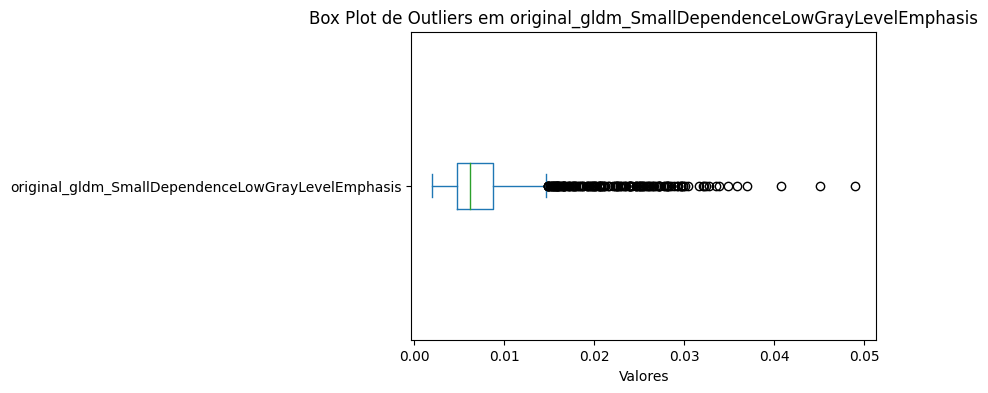

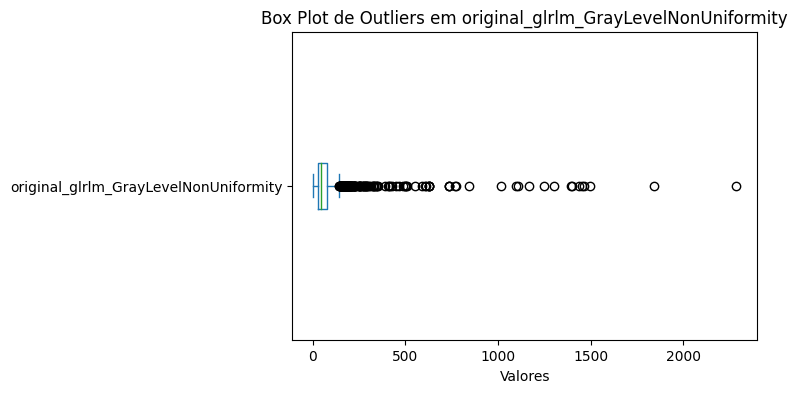

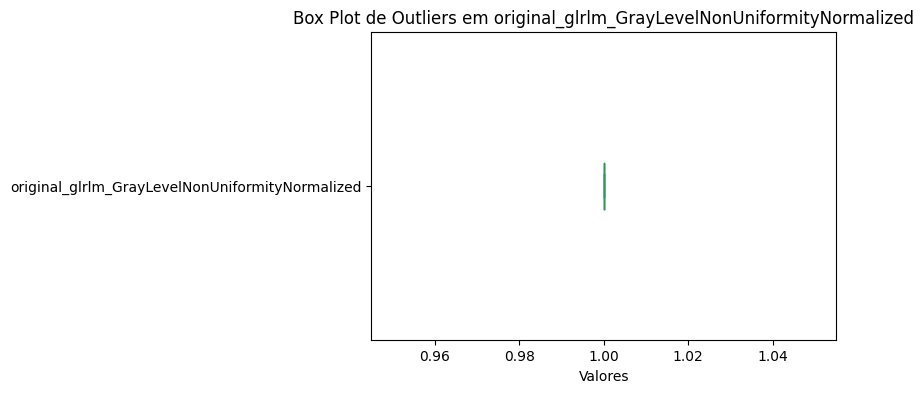

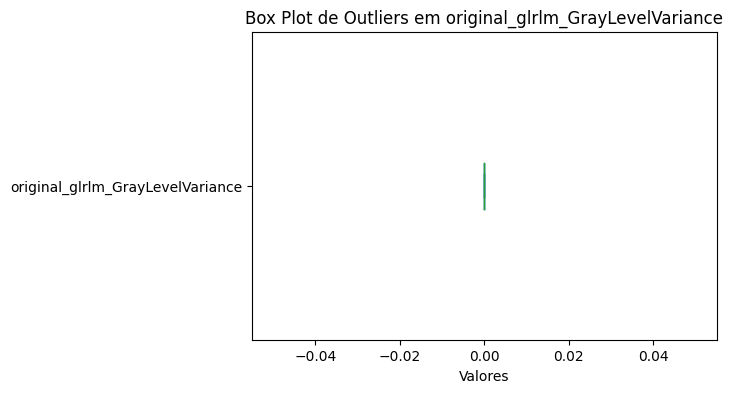

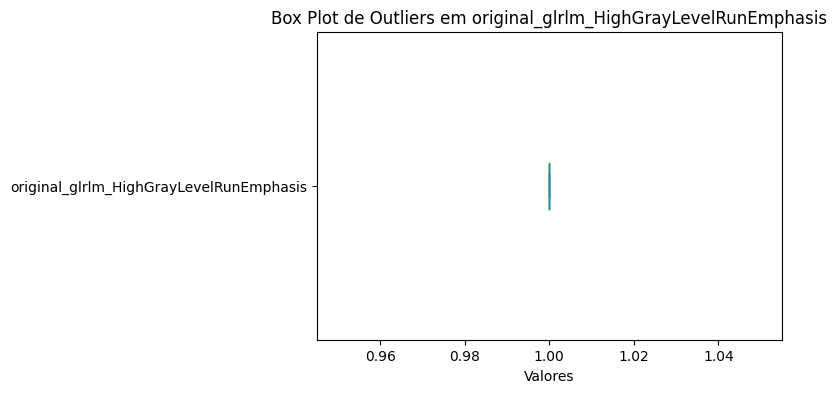

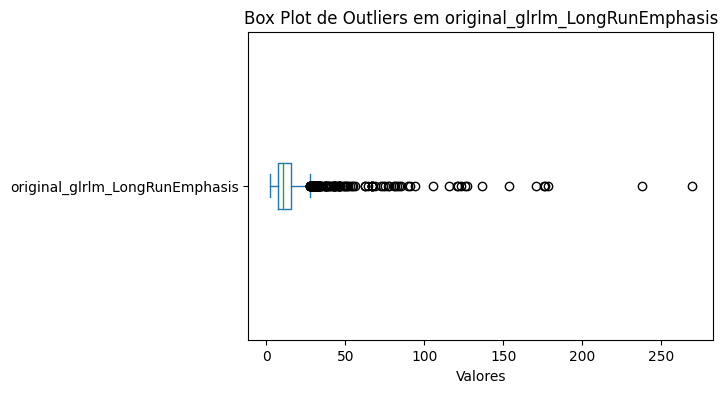

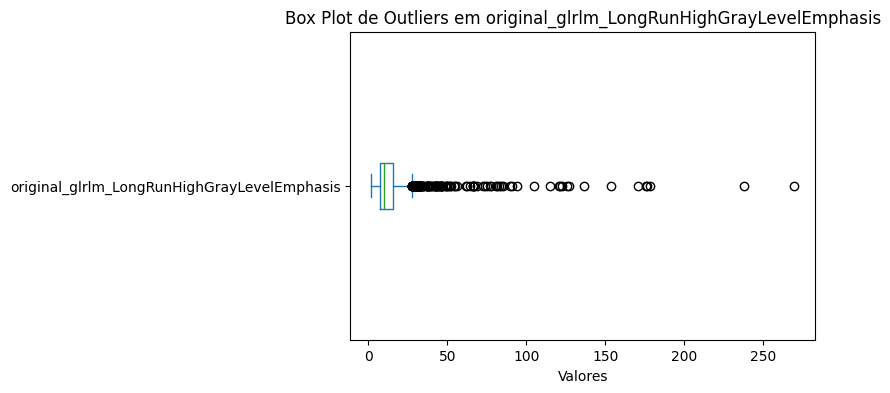

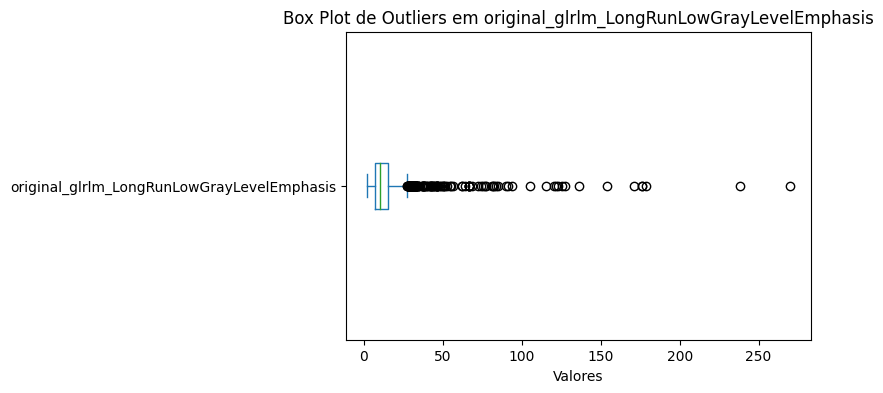

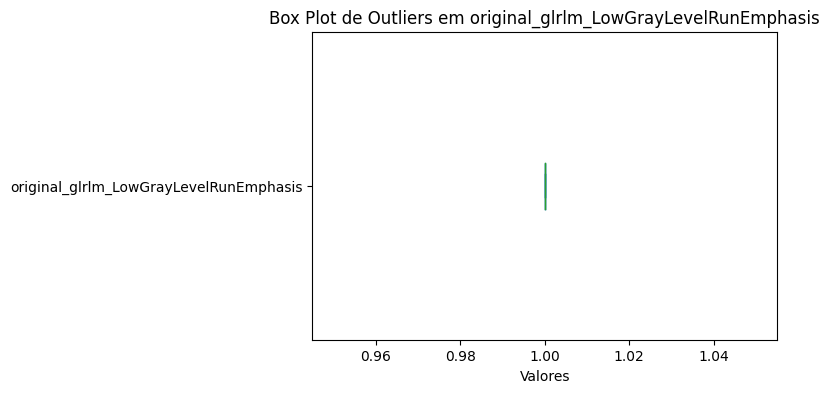

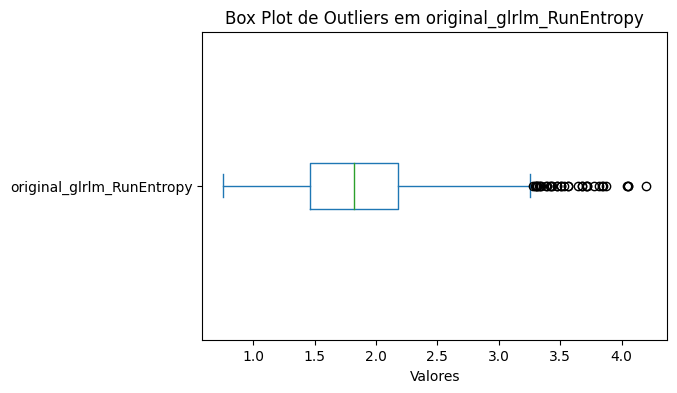

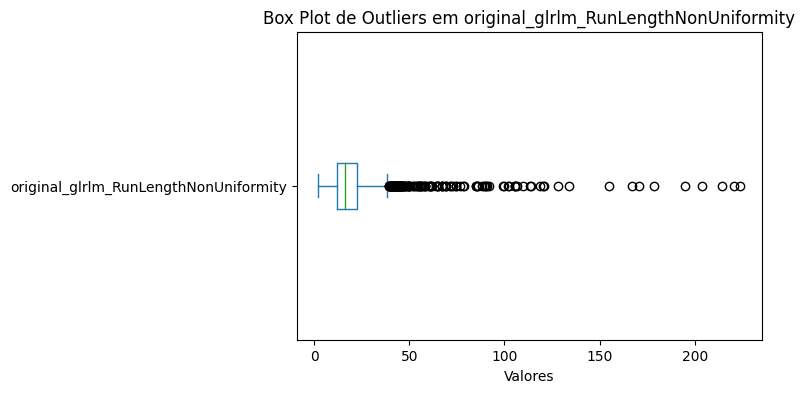

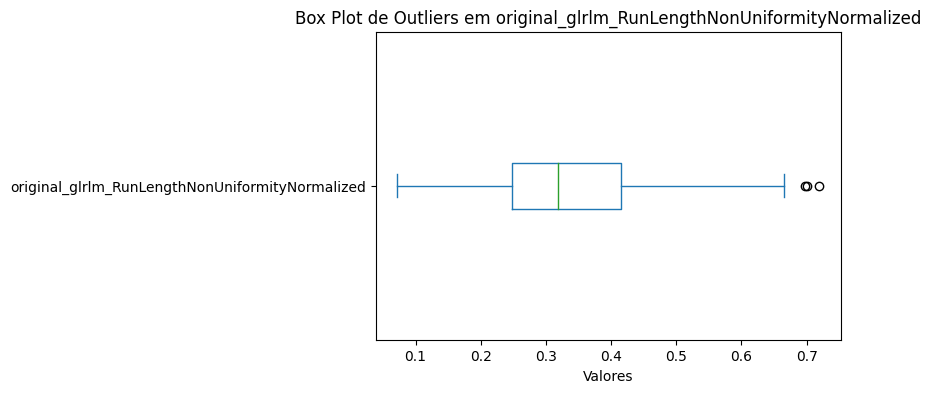

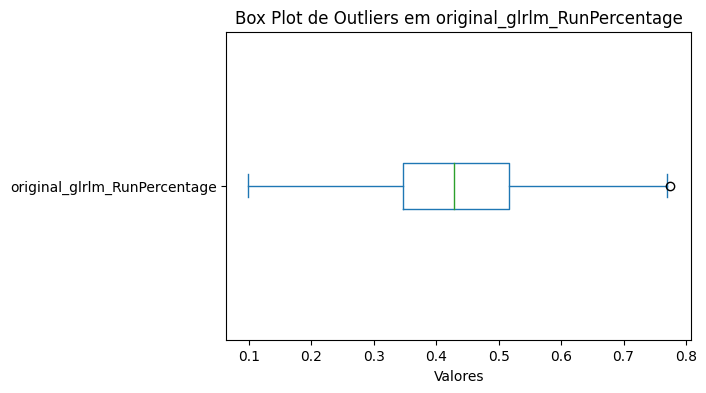

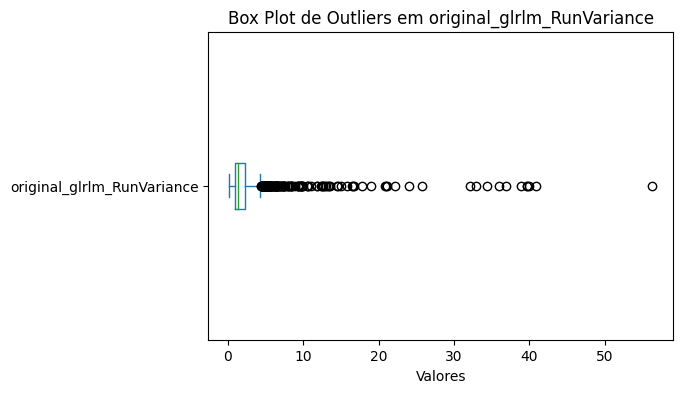

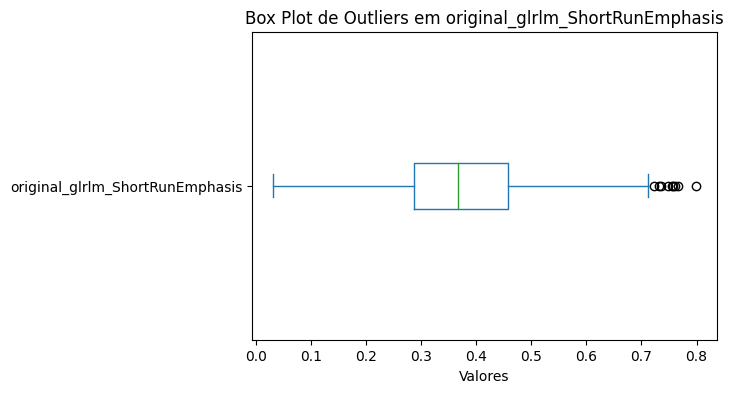

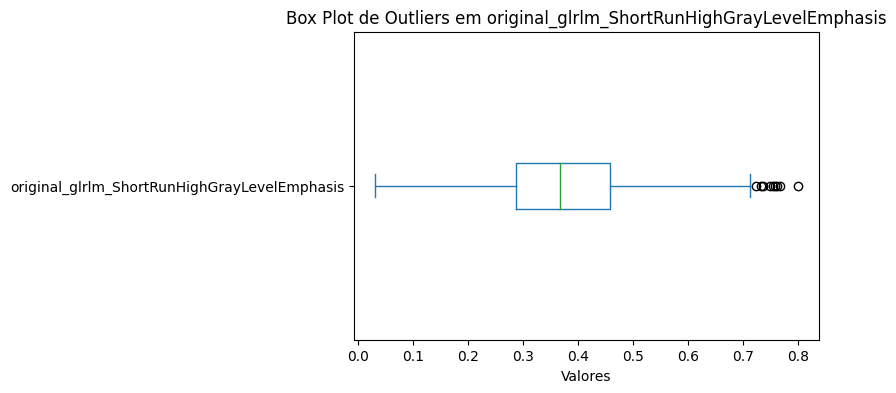

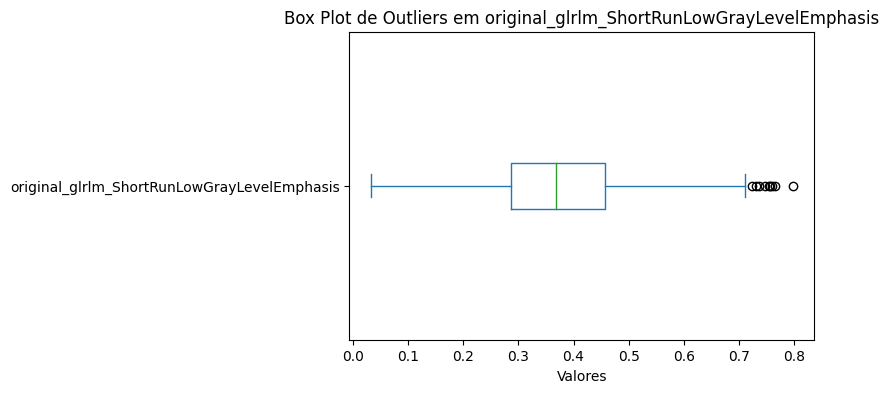

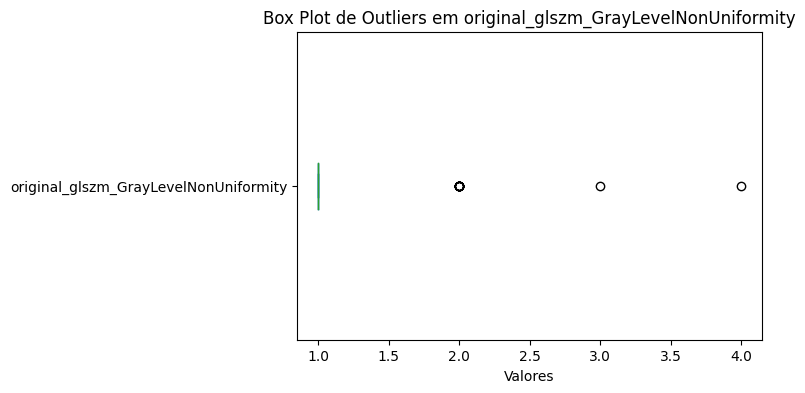

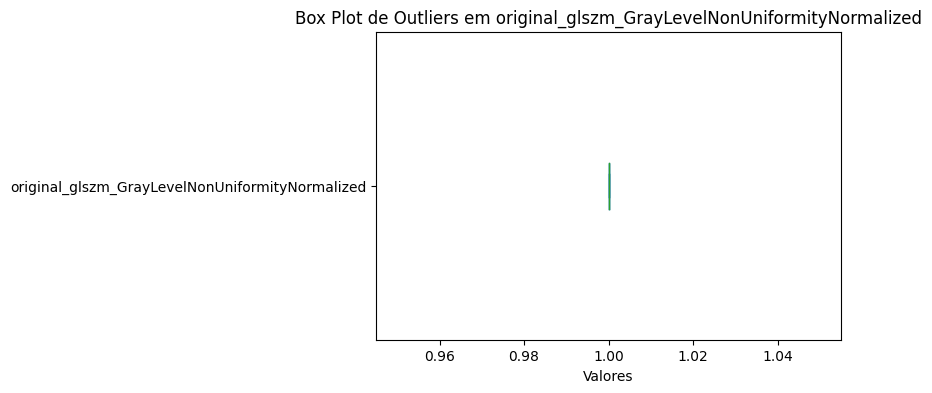

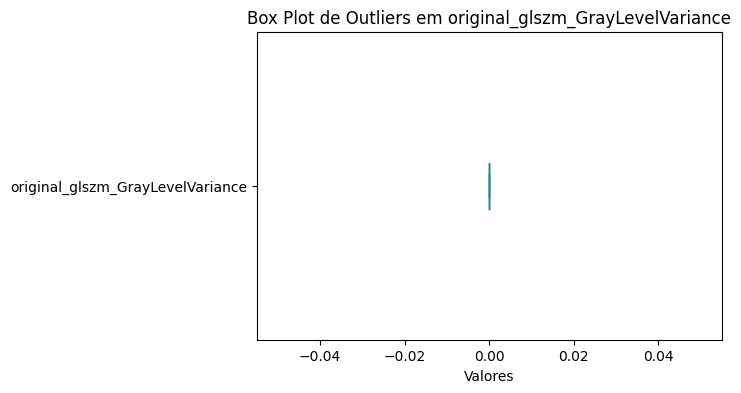

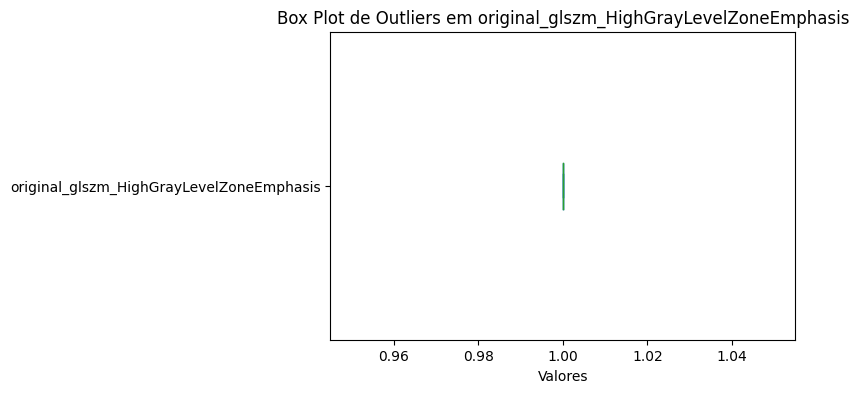

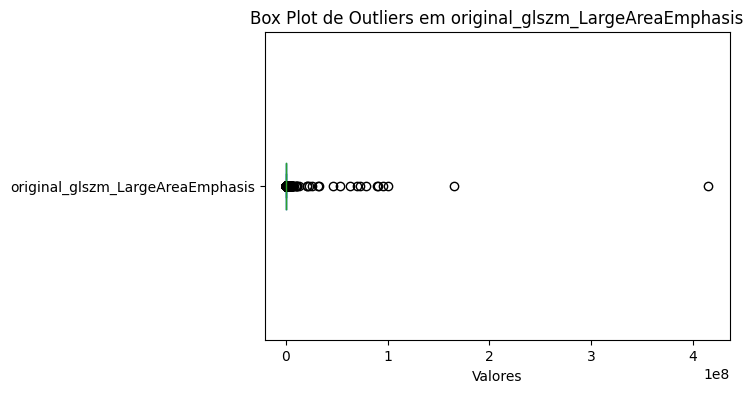

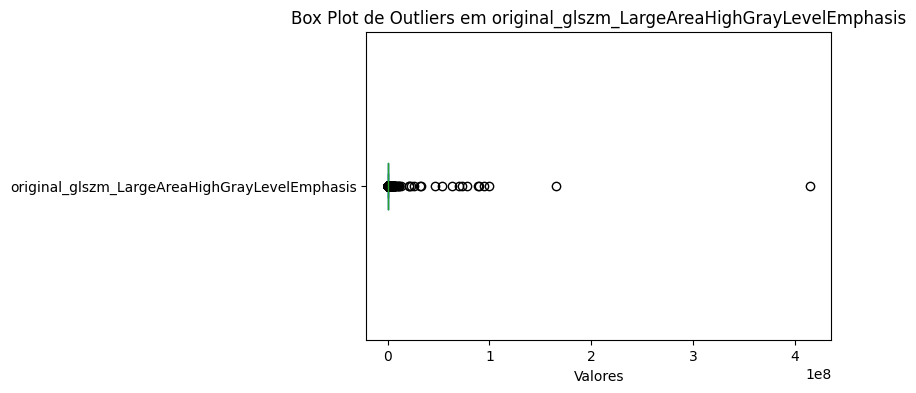

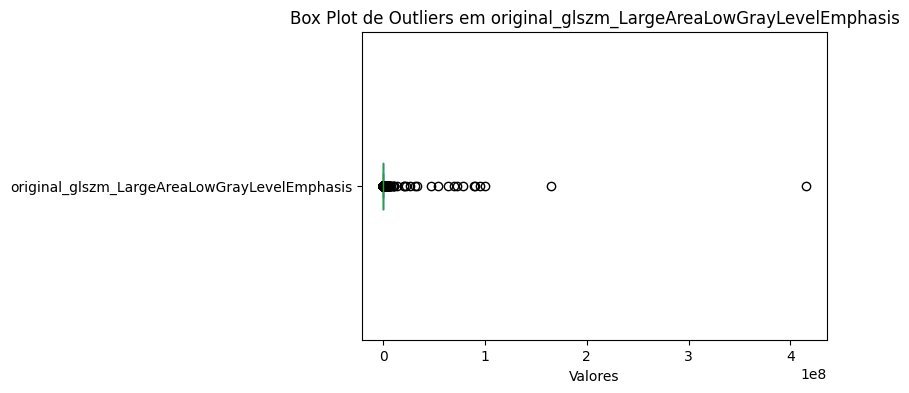

/tmp/ipykernel_32358/4043802005.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  outliers_df[coluna] = outliers.astype(int)


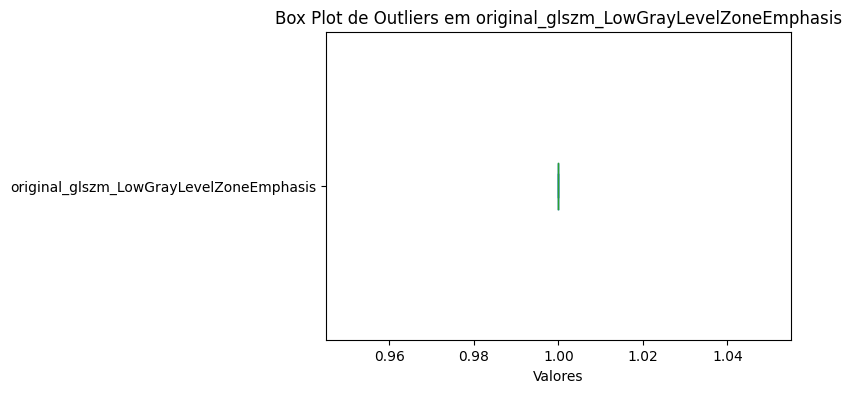

/tmp/ipykernel_32358/4043802005.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  outliers_df[coluna] = outliers.astype(int)


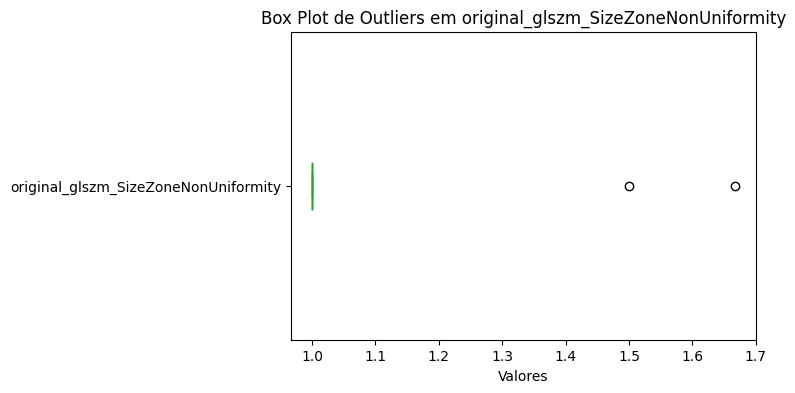

/tmp/ipykernel_32358/4043802005.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  outliers_df[coluna] = outliers.astype(int)


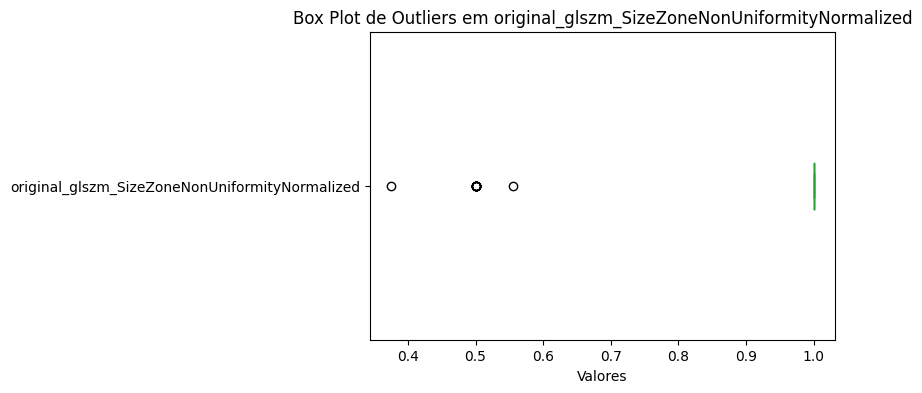

/tmp/ipykernel_32358/4043802005.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  outliers_df[coluna] = outliers.astype(int)


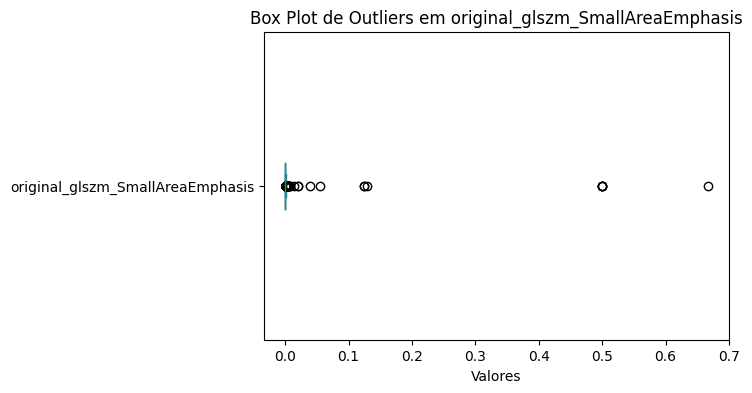

/tmp/ipykernel_32358/4043802005.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  outliers_df[coluna] = outliers.astype(int)


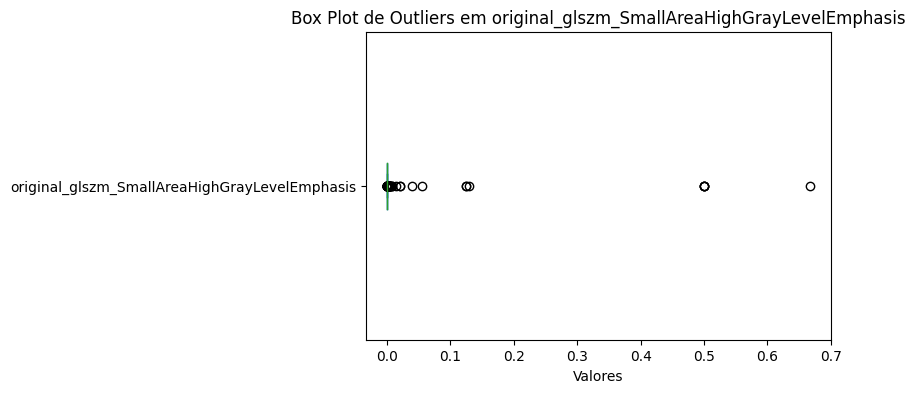

/tmp/ipykernel_32358/4043802005.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  outliers_df[coluna] = outliers.astype(int)


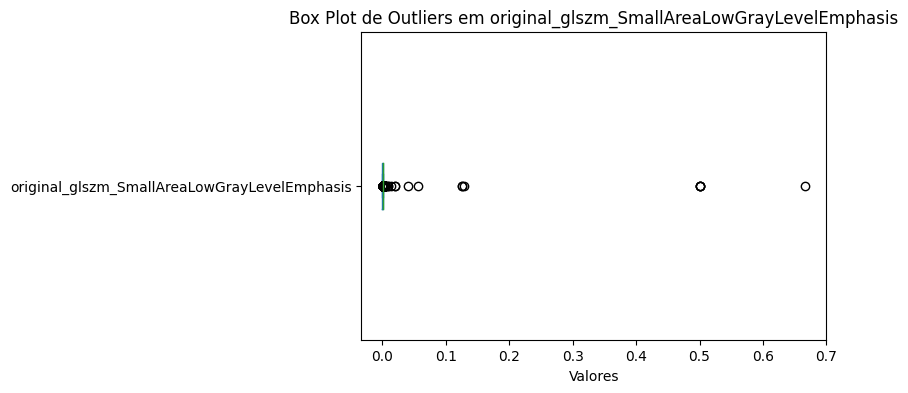

/tmp/ipykernel_32358/4043802005.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  outliers_df[coluna] = outliers.astype(int)


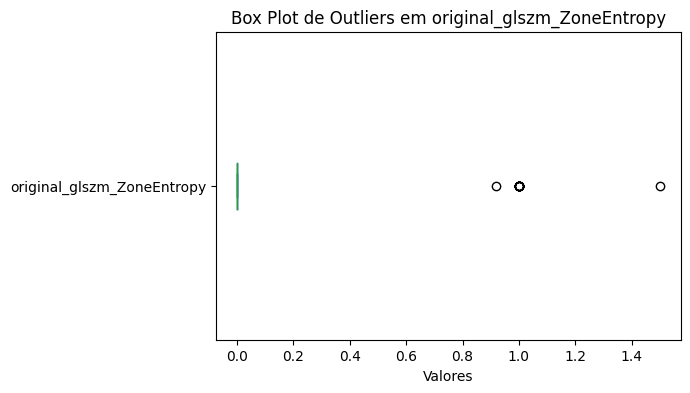

/tmp/ipykernel_32358/4043802005.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  outliers_df[coluna] = outliers.astype(int)


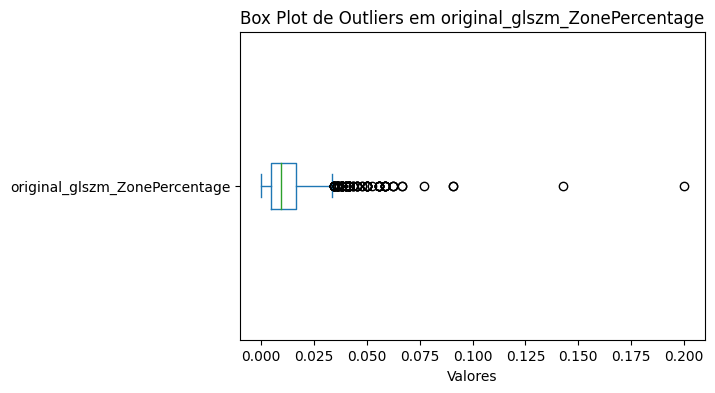

/tmp/ipykernel_32358/4043802005.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  outliers_df[coluna] = outliers.astype(int)


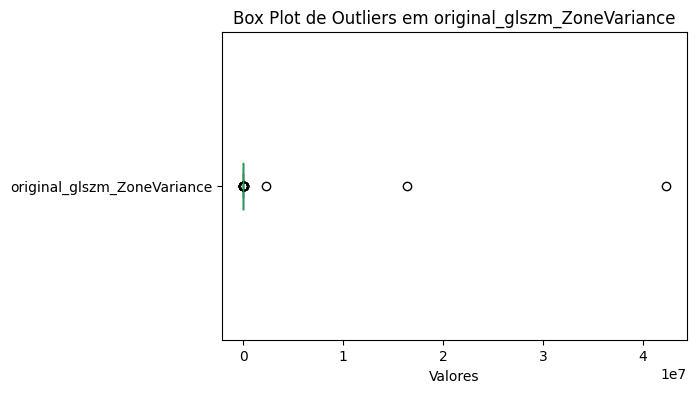

/tmp/ipykernel_32358/4043802005.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  outliers_df[coluna] = outliers.astype(int)


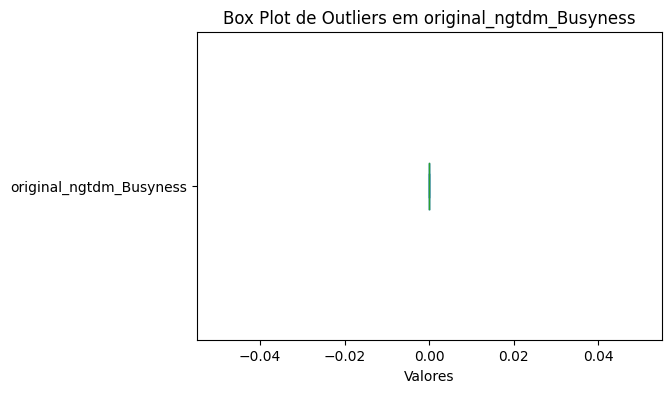

/tmp/ipykernel_32358/4043802005.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  outliers_df[coluna] = outliers.astype(int)


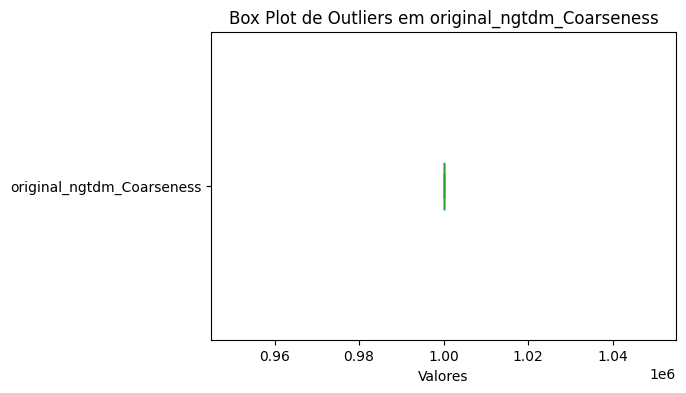

/tmp/ipykernel_32358/4043802005.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  outliers_df[coluna] = outliers.astype(int)


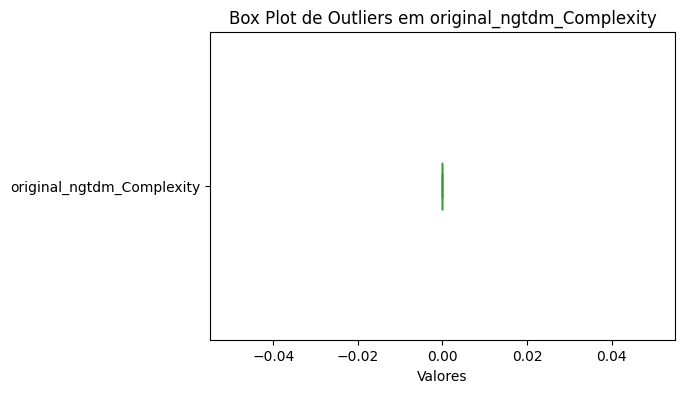

/tmp/ipykernel_32358/4043802005.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  outliers_df[coluna] = outliers.astype(int)


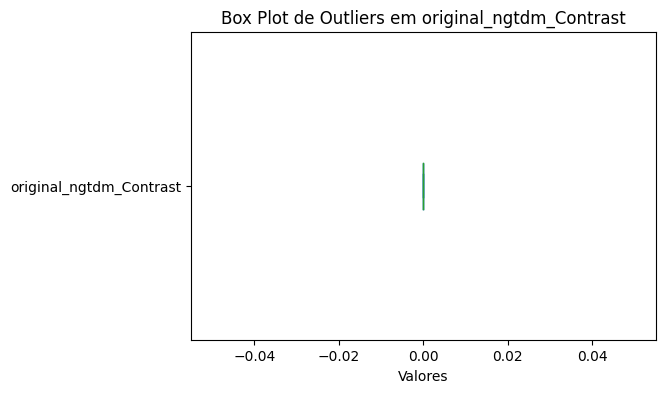

/tmp/ipykernel_32358/4043802005.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  outliers_df[coluna] = outliers.astype(int)


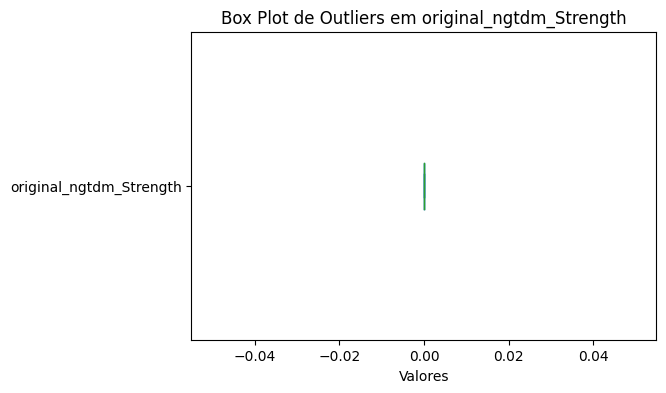

/tmp/ipykernel_32358/4043802005.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  outliers_df[coluna] = outliers.astype(int)


      subtlety  internalStructure  calcification  sphericity  margin  \
0          NaN                NaN            NaN         NaN     NaN   
1          NaN                NaN            NaN         NaN     NaN   
2          0.0                0.0            0.0         0.0     0.0   
3          NaN                NaN            NaN         NaN     NaN   
4          NaN                NaN            NaN         NaN     NaN   
...        ...                ...            ...         ...     ...   
2646       NaN                NaN            NaN         NaN     NaN   
2647       NaN                NaN            NaN         NaN     NaN   
2648       NaN                NaN            NaN         NaN     NaN   
2649       0.0                0.0            0.0         0.0     0.0   
2650       0.0                0.0            1.0         0.0     0.0   

      lobulation  spiculation  texture  original_shape_Elongation  \
0            NaN          NaN      NaN                        NaN 

In [48]:

populacao_sem_cancro = []

for i in range(len(values)):
    if values[i] == 0:
        populacao_sem_cancro.append(i)


outliers_df = pd.DataFrame(index=X.index)


for coluna in X.columns:
    data_plot1 = X[X.index.isin(populacao_sem_cancro)]
    data_plot = data_plot1[coluna]
    
    
    plt.figure(figsize=(6, 4))
    data_plot.plot.box(vert=False)
    plt.title(f'Box Plot de Outliers em {coluna}')
    plt.xlabel('Valores')
    plt.show()

  l
    limite = 3 
    z_scores = np.abs((data_plot - data_plot.mean()) / data_plot.std())
    outliers = z_scores > limite
    outliers_df[coluna] = outliers.astype(int)

print(outliers_df)

In [49]:
outliers_df['Total'] = outliers_df.sum(axis=1)



indicetirar=[]
outliers20=outliers_df['Total'].tolist()
for i in range(len(outliers20)):
    if outliers20[i]<=20:
        indicetirar.append(i)


X2=X.iloc[indicetirar]



y_alterado = [valor for i, valor in enumerate(values) if i in indicetirar]

In [99]:
oversample = SMOTE()
counter = Counter(y_alterado)
print(counter)

Counter({0: 1966, 1: 670})


Aqui efetuamos o data augmentation para igualar o número de elementos. 

In [51]:
X2, y2 = oversample.fit_resample(X2, y_alterado)
print(Counter(y2))

Counter({1: 1966, 0: 1966})


In [52]:
scaler = StandardScaler()

X_continuous = scaler.fit_transform(X2)

scaled = pd.DataFrame(X_continuous, columns=X2.columns)
X_train, X_test, y_train, y_test = train_test_split(scaled, y2, test_size=0.3)

Após efetuar novamente o Standard-Scalling, decidimos voltar a executar os quatro algoritmos com o novo conjunto de labels equilibradas.

Os resultados obtidos após a mudança dos dados serão analisados no final do documento em comparação com os dados obtidos anteriormente.

Fitting 5 folds for each of 108 candidates, totalling 540 fits


/home/guilherme/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
180 fits failed out of a total of 540.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
180 fits failed with the following error:
Traceback (most recent call last):
  File "/home/guilherme/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/guilherme/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 340, in fit
    self._validate_params()
  File "/home/guilherme/.local/lib/python3.8/site-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/home/

RandomForestClassifier(n_estimators=200)
              precision    recall  f1-score   support

           0       0.89      0.88      0.88       578
           1       0.89      0.89      0.89       602

    accuracy                           0.89      1180
   macro avg       0.89      0.89      0.89      1180
weighted avg       0.89      0.89      0.89      1180

Accuracy: 0.885593220338983
Precision: 0.8859504132231405
Recall: 0.8903654485049833


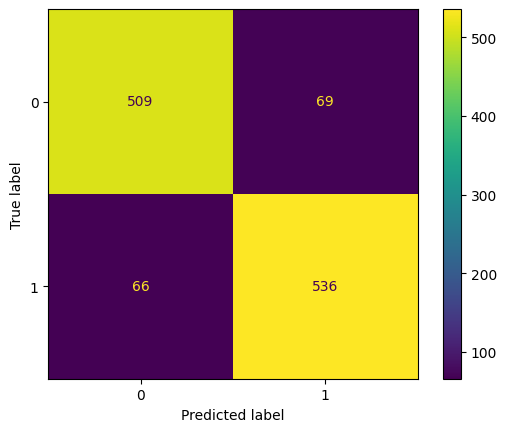

In [53]:
param_grid={'max_depth':[3,5,10,None],
              'n_estimators':[10,100,200],
              'min_samples_leaf':[1,2,3],
              'min_samples_split':[1,2,3]
           }


grid = GridSearchCV(RandomForestClassifier(),param_grid,refit=True,verbose=1);
grid.fit(X_train, y_train)
print(grid.best_estimator_)

grid_predictions = grid.predict(X_test)
print(classification_report(y_test,grid_predictions))


cm = confusion_matrix(y_test, grid_predictions)
ConfusionMatrixDisplay(confusion_matrix=cm).plot();

accuracy = accuracy_score(y_test, grid_predictions)
precision = precision_score(y_test, grid_predictions)
recall = recall_score(y_test, grid_predictions)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
best_rf_da=grid

In [54]:
print(grid.best_params_)

{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


SVC(C=100, gamma=0.01)
              precision    recall  f1-score   support

           0       0.86      0.86      0.86       578
           1       0.87      0.87      0.87       602

    accuracy                           0.86      1180
   macro avg       0.86      0.86      0.86      1180
weighted avg       0.86      0.86      0.86      1180



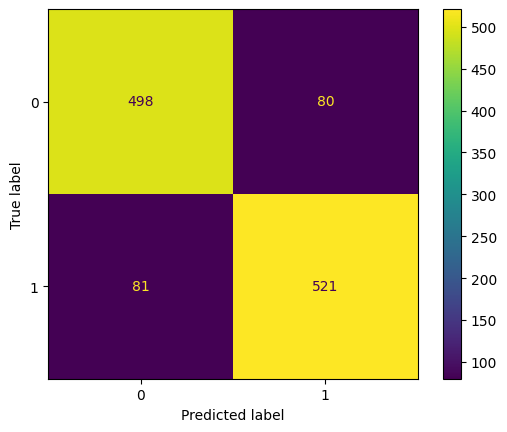

In [55]:
melhor=0

param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid','linear']}
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=0);
grid.fit(X_train, y_train)
print(grid.best_estimator_)

grid_predictions = grid.predict(X_test)
print(classification_report(y_test,grid_predictions))

best_svm_da=grid
cm = confusion_matrix(y_test, grid_predictions)
ConfusionMatrixDisplay(confusion_matrix=cm).plot();

Acurácia: 0.8694915254237288
Precision: 0.8862068965517241
Recall: 0.8538205980066446
4


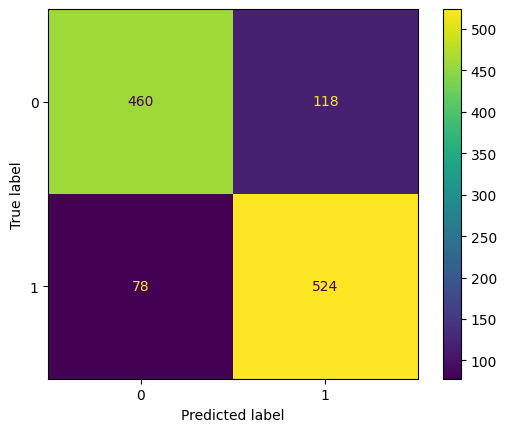

In [56]:
from sklearn.neighbors import KNeighborsClassifier

melhor=0

for k in range(1,100):

    knn_classifier = KNeighborsClassifier(n_neighbors=k)

  
    knn_classifier.fit(X_train, y_train)


    y_pred = knn_classifier.predict(X_test)

   
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    if accuracy>melhor:
        melhork=k
        melhor=accuracy
        melhorp=precision
        melhorr=recall
        best_knn_da=knn_classifier
print(f"Acurácia: {melhor}")
print("Precision:", melhorp)
print("Recall:", melhorr)
print(melhork)
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot();

In [57]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split


X_NN = X_train.values.tolist()
y_NN = y_train


hidden_layer_sizes = [(12, 8), (10, 6), (8, 4)]
epochs_list = [100, 150, 200]
batch_size_list = [5, 10, 20]

best_accuracy = 0
best_model = None


accuracies = []
losses = []


for hidden_layers in hidden_layer_sizes:
    for epochs in epochs_list:
        for batch_size in batch_size_list:

            model = Sequential()
            for units in hidden_layers:
                model.add(Dense(units, activation='relu', input_shape=(X_train.shape[1],)))
            model.add(Dense(1, activation='sigmoid'))
            

            model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
            

            history = model.fit(X_NN, y_NN, epochs=epochs, batch_size=batch_size, verbose=0)
            

            loss, accuracy = model.evaluate(X_test.values.tolist(), y_test, verbose=0)
            
            
            accuracies.append(accuracy)
            losses.append(loss)
            
                        if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_model = model
print('Melhor accuracy: ', best_accuracy)
best_nn_da=best_model

Melhor accuracy:  0.8686440587043762


37/37 [==============================] - 0s 630us/step
              precision    recall  f1-score   support

           0       0.87      0.86      0.87       578
           1       0.87      0.88      0.87       602

    accuracy                           0.87      1180
   macro avg       0.87      0.87      0.87      1180
weighted avg       0.87      0.87      0.87      1180



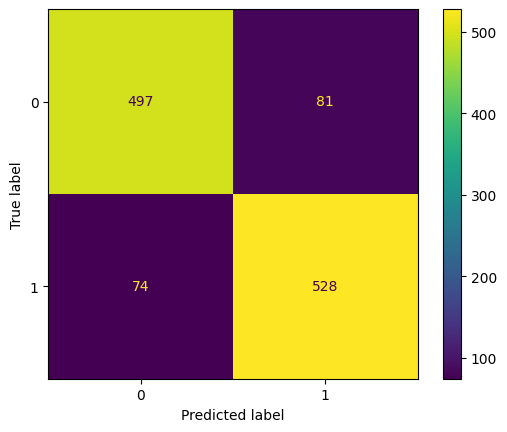

In [58]:
grid_predictions = best_model.predict(X_test)

count=0
f=[0]*len(grid_predictions)
for value in grid_predictions:
    if value>=0.5:
        f[count]=1
    else:
        f[count]=0
    count+=1


print(classification_report(y_test,f))

cm = confusion_matrix(y_test, f)
ConfusionMatrixDisplay(confusion_matrix=cm).plot();


# Análise de resultados e conclusões

Quanto à analíse de resultados, o grupo decidiu optar por vários métodos. 

Inicialmente optámos por fazer várias curvas ROC, como é visivel a baixo.

Decidimos também separar essas curvas, de modo a perceber o efeito da Data augmentation.

Resultados sem data augmentation:

37/37 [==============================] - 0s 859us/step


Text(0.5, 1.0, 'Curva ROC')

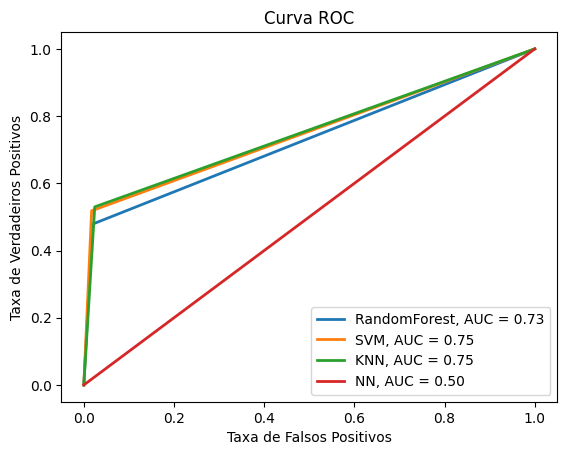

In [98]:
from sklearn.metrics import roc_auc_score, roc_curve


modelos_nda = {
    'RandomForest':best_rf_nda,
    'SVM':best_svm_nda,
    'KNN':best_knn_nda,
    'NN':best_NN_nda
}

auc_list_nda=[]
for key in modelos_nda:
    y_pred = modelos_nda[key].predict(X_test)  
    auc = roc_auc_score(y_test, y_pred)
    auc_list.append(auc)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)


    plt.plot(fpr, tpr, lw=2, label=f'{key}, AUC = {auc:.2f}')
plt.legend(loc="lower right")
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')

Resultados com Data augmentattion:

37/37 [==============================] - 0s 621us/step


Text(0.5, 1.0, 'Curva ROC')

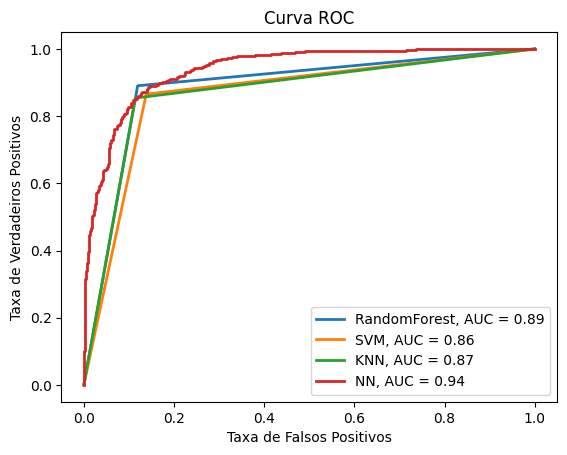

In [77]:

modelos_da = {
    'RandomForest':best_rf_da,
    'SVM':best_svm_da,
    'KNN':best_knn_da,
    'NN':best_nn_da
}

auc_list_da=[]
for key in modelos_da:
    y_pred = modelos_da[key].predict(X_test) 
    auc = roc_auc_score(y_test, y_pred)
    auc_list.append(auc)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)

    plt.plot(fpr, tpr, lw=2, label=f'{key}, AUC = {auc:.2f}')

plt.legend(loc="lower right")
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')

Resultados sem data augmentation comparados entre si:

37/37 [==============================] - 0s 732us/step


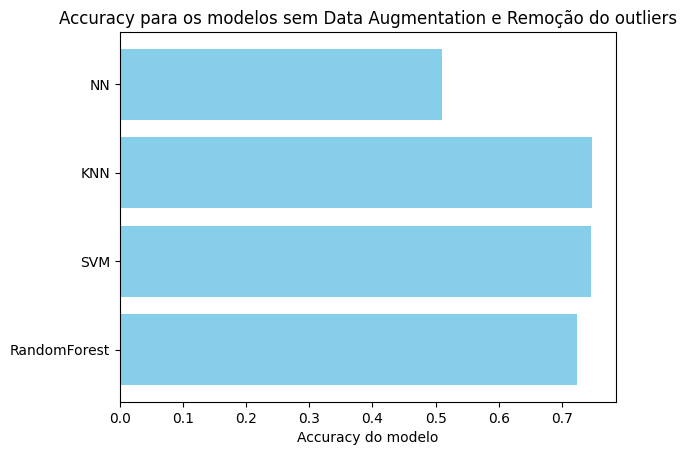

In [96]:
acc_list=[]
xs=[]
for key in modelos_nda:
    y_pred = modelos_nda[key].predict(X_test)
    f=[]
    for value in y_pred:
        if value>=0.5:
            f.append(1)
        else:
            f.append(0)
    acc=accuracy_score(y_test, f)
    acc_list.append(acc)
    xs.append(key)
    
plt.barh(xs, acc_list, color='skyblue')
plt.xlabel('Accuracy do modelo')
plt.title('Accuracy para os modelos sem Data Augmentation e Remoção do outliers')
plt.show()


Dados com data augmentation:

37/37 [==============================] - 0s 615us/step


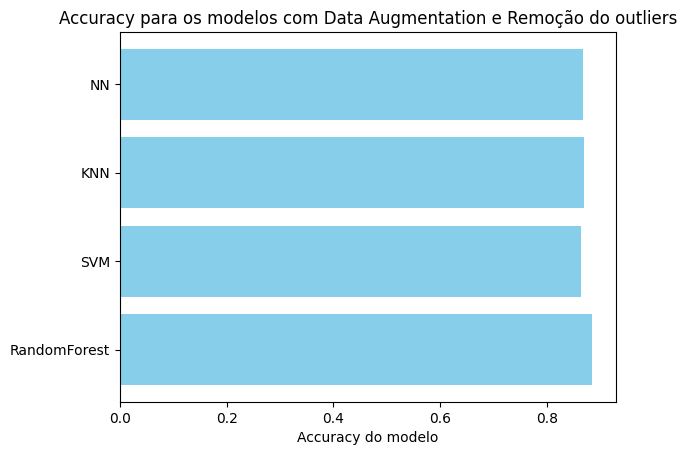

In [97]:
acc_list=[]
xs=[]
for key in modelos_da:
    y_pred = modelos_da[key].predict(X_test)
    f=[]
    for value in y_pred:
        if value>=0.5:
            f.append(1)
        else:
            f.append(0)
    acc=accuracy_score(y_test, f)
    acc_list.append(acc)
    xs.append(key)
    
plt.barh(xs, acc_list, color='skyblue')
plt.xlabel('Accuracy do modelo')
plt.title('Accuracy para os modelos com Data Augmentation e Remoção do outliers')
plt.show()


## Análise de resultados

A principal conclusão retirada foi de que os efeitos da Data augmentation foram notórios naquilo que foi a accuracy dos modelos. 

O desempenho do RandomForest foi, segundo a métrica da accuracy, o modelo que atingiu um melhor resultado, enquanto que a ROC curve apresentou melhor desempenho na NN. Acreditamos que isto pode ter algumas razões e dever-se a uma combinação de fatores, dentre os quais uma possível escolha de hiperparâmetros, pois a NN possui mais hiperparâmetros, o tamanho do conjunto de dados ou aquela que para nós nos parece ser o verdadeiro motivo, que é o desequilíbrio de classes, pois antes da data augmentation a curva ROC do NN apresentava um desempenho consideravelmente pior, comparado aos restantes modelos e em especial ao Random Forest.  

## Conclusão

Acreditamos que o principal objetivo deste trabalho, isto é, a elaboração de um modelo de aprendizagem computacional, capaz de detetar com "accuracy" a cima da média, se um paciente tem cancro com base nos seus TAC's foi atingido.
O grupo considerou como um todo um trabalho interessante e desafiante. Achamos que a extração de features foi particularmente interessante, pois nunca o tinhamos o tinhamos feito utilizando uma ferramenta como o radiomics.
Apesar do desafio, nós consideramos que este projecto contribuiu não só para o aumento da nossa proficiência e conhecimento naquilo que é a aréa de Data Science, mas também contribuiu para o desenvolvimento de soft skills importantes na nossa vida académica e profissional, como trabalho o trabalho em grupo e a capacidade de comunicação.